#Carga de datos

In [0]:
dfPopulation = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/poblacion.csv")

dfPoverty = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/pobreza.csv")

dfArrests = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/arrestos.csv")

dfCrashes = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/colisiones.csv")

df5 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/mawilliam@javeriana.edu.co/2016___2017_Health_Education_Report.csv")


#Exploración de los datos

Porcentaje de arrestos según población total por localidad

In [0]:
from pyspark.sql.functions import split,when
import pandas as pd



dfArrests = dfArrests.withColumn("ARREST_BORO",when(dfArrests["ARREST_BORO"] == "K", "Brooklyn").when(dfArrests["ARREST_BORO"] == "B", "Bronx").when(dfArrests["ARREST_BORO"] == "M", "Manhattan").when(dfArrests["ARREST_BORO"] == "Q", "Queens").when(dfArrests["ARREST_BORO"] == "S", "Staten Island").otherwise(dfArrests["ARREST_BORO"]))



dfPopulation2022 = dfPopulation[["Borough","2020","2020 - Boro share of NYC total"]].withColumnRenamed("2020","year2020")
dfPopulation2022 = spark.createDataFrame(dfPopulation2022.tail(dfPopulation2022.count()-1), dfPopulation2022.schema).sort("Borough")
dfPopulation2022 = dfPopulation2022.withColumnRenamed("Borough","ARREST_BORO")

#display(dfPopulation2022)

dfArrestsDate = dfArrests.withColumn('month', split(dfArrests['ARREST_DATE'], '/').getItem(0)) \
       .withColumn('day', split(dfArrests['ARREST_DATE'], '/').getItem(1)) \
       .withColumn('year', split(dfArrests['ARREST_DATE'], '/').getItem(2))

#display(dfArrestsDate)
por_year = dfArrestsDate.groupBy("year").count()
por_boro = dfArrestsDate.groupBy("ARREST_BORO").count().sort("ARREST_BORO")
por_boro = por_boro.withColumnRenamed("count","cantidad")
#display(por_boro)
por_borodf=por_boro.toPandas()
population2022Df= dfPopulation2022.toPandas()

#join=dfPopulation2022.join(por_boro,"ARREST_BORO").select("ARREST_BORO",  (por_boro.cantidad / dfPopulation2022["2020 - Boro share of NYC total"]).alias("product"))

por_borodf["Porcentaje según población total"]= (por_borodf["cantidad"]*100)/population2022Df["year2020"]

percentajePerBorough = spark.createDataFrame(por_borodf) 
display(percentajePerBorough.withColumnRenamed("ARREST_BORO","Arrestos"))


Arrestos cantidad Porcentaje según población total Bronx 21198 1.4651766533866746 Brooklyn 25431 0.960221291531808 Manhattan 22997 1.4037274435826332 Queens 19416 0.83319923014039 Staten Island 4196 0.8613275035666267

Cantidad de arrestos según edad y sexo

In [0]:


dfPeople = dfArrests.groupBy("AGE_GROUP","PERP_SEX").count().sort("AGE_GROUP").withColumnRenamed("PERP_SEX","Género").withColumnRenamed("AGE_GROUP","Rango de edades").withColumnRenamed("count","Cantidad")

display(dfPeople)


Rango de edades Género Cantidad 18-24 F 3054 18-24 M 13201 25-44 M 44094 25-44 F 9664 45-64 M 15795 45-64 F 2696 65+ F 212 65+ M 1138 <18 F 643 <18 M 2741

Cantidad de arrestos según raza y sexo

In [0]:
dfPeople2 = dfArrests.groupBy("PERP_RACE","PERP_SEX").count().sort("PERP_RACE").withColumnRenamed("PERP_RACE","Raza").withColumnRenamed("count","Cantidad").withColumnRenamed("PERP_SEX","Género")
display(dfPeople2)

Raza Género Cantidad AMERICAN INDIAN/ALASKAN NATIVE M 207 AMERICAN INDIAN/ALASKAN NATIVE F 32 ASIAN / PACIFIC ISLANDER M 4232 ASIAN / PACIFIC ISLANDER F 774 BLACK M 37854 BLACK F 8260 BLACK HISPANIC M 7002 BLACK HISPANIC F 1204 UNKNOWN M 291 UNKNOWN F 40 WHITE M 7980 WHITE F 1982 WHITE HISPANIC M 19403 WHITE HISPANIC F 3977

Cantidad de accidentes según tipo de vehículo

In [0]:
from pyspark.sql.functions import split,when,col




porTipoVehículo = dfCrashes.groupBy("VEHICLE_TYPE").count().sort(col("count").desc())
#display(porTipoVehículo.schema)
porTipoVehículo=porTipoVehículo.withColumn("VEHICLE_TYPE",when(col("VEHICLE_TYPE").isNull(), "Sin información").otherwise(porTipoVehículo["VEHICLE_TYPE"])).withColumnRenamed("count","Cantidad").withColumnRenamed("VEHICLE_TYPE","TipoDeVehículo")
porTipoVehículo=porTipoVehículo.head(10)
display(porTipoVehículo)


TipoDeVehículo Cantidad PASSENGER VEHICLE 770756 Sedan 653589 Station Wagon/Sport Utility Vehicle 532612 SPORT UTILITY / STATION WAGON 337927 Sin información 120557 UNKNOWN 105357 4 dr sedan 72852 Taxi 69713 TAXI 60785 VAN 49720

Cantidad de accidentes según licencia del conductor

In [0]:
porLicencia = dfCrashes.groupBy("DRIVER_LICENSE_STATUS").count()

porLicencia=porLicencia.withColumn("DRIVER_LICENSE_STATUS",when(col("DRIVER_LICENSE_STATUS").isNull(), "Sin información").otherwise(porLicencia["DRIVER_LICENSE_STATUS"])).withColumnRenamed("DRIVER_LICENSE_STATUS","EstadoDeLaLicenciaDelConductor").withColumnRenamed("count","Cantidad")
display(porLicencia)

EstadoDeLaLicenciaDelConductor Cantidad Sin información 1935085 Unlicensed 18995 Permit 7763 Licensed 1235864

Cantidad de accidentes según factor contribuidor

In [0]:
porFactor = dfCrashes.groupBy("CONTRIBUTING_FACTOR_1").count().sort(col("count").desc()).withColumnRenamed("CONTRIBUTING_FACTOR_1","Factor que contribuye")

porFactor=porFactor.withColumn("Factor que contribuye",when(col("Factor que contribuye").isNull(), "Sin información").otherwise(porFactor["Factor que contribuye"])).withColumnRenamed("count","Cantidad")

porFactor=porFactor.head(10)
display(porFactor)

Factor que contribuye Cantidad Unspecified 1872007 Driver Inattention/Distraction 371555 Failure to Yield Right-of-Way 105741 Following Too Closely 93570 Sin información 85797 Other Vehicular 79901 Backing Unsafely 68571 Fatigued/Drowsy 59690 Turning Improperly 49183 Passing or Lane Usage Improper 46758

Cantidad de personas consideradas en probreza

In [0]:


porCantidadPobreza=  dfPoverty.groupBy("NYCgov_Pov_Stat").count().withColumnRenamed("NYCgov_Pov_Stat","EstadoDePobreza")

porCantidadPobreza=porCantidadPobreza.withColumn("EstadoDePobreza",when(porCantidadPobreza["EstadoDePobreza"] == "1", "En pobreza").when(porCantidadPobreza["EstadoDePobreza"] == "2", "No en pobreza").otherwise(porCantidadPobreza["EstadoDePobreza"]))
display(porCantidadPobreza)


EstadoDePobreza count En pobreza 12113 No en pobreza 56160

Estado laboral de las personas según clasificación en índice de pobreza

In [0]:
porEstadoLaboral=  dfPoverty.groupBy("NYCgov_Pov_Stat","ESR").count().withColumnRenamed("ESR","EstadoLaboral").withColumnRenamed("NYCgov_Pov_Stat","EstadoDePobreza").withColumnRenamed("count","Cantidad").sort("EstadoLaboral")

porEstadoLaboral=porEstadoLaboral.withColumn("EstadoDePobreza",when(porEstadoLaboral["EstadoDePobreza"] == "1", "En pobreza").when(porEstadoLaboral["EstadoDePobreza"] == "2", "No en pobreza").otherwise(porEstadoLaboral["EstadoDePobreza"]))
porEstadoLaboral=porEstadoLaboral.withColumn("EstadoLaboral",when(porEstadoLaboral["EstadoLaboral"] == "1", "EmpleadoConEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "2", "EmpleadoConTrabajoPeroNoEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "3", "Desempleado").when(porEstadoLaboral["EstadoLaboral"] == "4", "FuerzasArmadasEnServicio").when(porEstadoLaboral["EstadoLaboral"] == "5", "FuerzasArmadasConTrabajoPeroNoEmpleo").when(porEstadoLaboral["EstadoLaboral"] == "6", "FueraDeLaFuerzaLaboral").when( col("EstadoLaboral").isNull(), "N/A (MenorA16Años)").otherwise(porEstadoLaboral["EstadoLaboral"]))
print(porEstadoLaboral.columns)
display(porEstadoLaboral.head(6))
display(porEstadoLaboral.tail(6))

['EstadoDePobreza', 'EstadoLaboral', 'Cantidad']


EstadoDePobreza EstadoLaboral Cantidad No en pobreza N/A (MenorA16Años) 9440 En pobreza N/A (MenorA16Años) 2358 En pobreza EmpleadoConEmpleo 3270 No en pobreza EmpleadoConEmpleo 30026 No en pobreza EmpleadoConTrabajoPeroNoEmpleo 739 En pobreza EmpleadoConTrabajoPeroNoEmpleo 126

EstadoDePobreza EstadoLaboral Cantidad No en pobreza Desempleado 1300 En pobreza Desempleado 629 No en pobreza FuerzasArmadasEnServicio 20 En pobreza FuerzasArmadasEnServicio 1 En pobreza FueraDeLaFuerzaLaboral 5729 No en pobreza FueraDeLaFuerzaLaboral 14635

#Reporte de calidad de los datos

In [0]:

from pyspark.sql.functions import count,isnan
display(dfArrests.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfArrests.columns]))

ARREST_KEY ARREST_DATE PD_CD PD_DESC KY_CD OFNS_DESC LAW_CODE LAW_CAT_CD ARREST_BORO ARREST_PRECINCT JURISDICTION_CODE AGE_GROUP PERP_SEX PERP_RACE X_COORD_CD Y_COORD_CD Latitude Longitude New Georeferenced Column 0 0 233 0 304 0 0 911 0 0 0 0 0 0 0 0 0 0 0

In [0]:
display(dfPoverty.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfPoverty.columns]))

SERIALNO SPORDER PWGTP WGTP AGEP CIT REL SCH SCHG SCHL SEX ESR LANX ENG MSP MAR WKW WKHP DIS JWTR NP TEN HHT AgeCateg Boro CitizenStatus EducAttain EST_Childcare EST_Commuting EST_EITC EST_FICAtax EST_HEAP EST_Housing EST_IncomeTax EST_MOOP EST_Nutrition EST_PovGap EST_PovGapIndex Ethnicity FamType_PU FTPTWork INTP_adj MRGP_adj NYCgov_Income NYCgov_Pov_Stat NYCgov_REL NYCgov_Threshold Off_Pov_Stat Off_Threshold OI_adj PA_adj Povunit_ID Povunit_Rel PreTaxIncome_PU RETP_adj RNTP_adj SEMP_adj SSIP_adj SSP_adj TotalWorkHrs_PU WAGP_adj 0 0 0 0 0 0 0 0 0 2107 0 11798 3533 37557 11021 0 31394 0 0 34956 0 0 0 0 0 0 2107 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [0]:
display(dfCrashes.select([count(when( col(c).isNull(), c)).alias(c) for c in dfCrashes.columns]))

UNIQUE_ID COLLISION_ID CRASH_DATE CRASH_TIME VEHICLE_ID STATE_REGISTRATION VEHICLE_TYPE VEHICLE_MAKE VEHICLE_MODEL VEHICLE_YEAR TRAVEL_DIRECTION VEHICLE_OCCUPANTS DRIVER_SEX DRIVER_LICENSE_STATUS DRIVER_LICENSE_JURISDICTION PRE_CRASH POINT_OF_IMPACT VEHICLE_DAMAGE VEHICLE_DAMAGE_1 VEHICLE_DAMAGE_2 VEHICLE_DAMAGE_3 PUBLIC_PROPERTY_DAMAGE PUBLIC_PROPERTY_DAMAGE_TYPE CONTRIBUTING_FACTOR_1 CONTRIBUTING_FACTOR_2 0 4 4 4 4 139480 120557 1699308 3146295 1705374 1600376 1655839 1883654 1935085 1925602 842075 1620201 1631058 2218511 2475744 2648148 1528868 3184853 85797 1612890

In [0]:
print('Count of rows: {0}'.format(dfCrashes.count()))
print('Count of distinct rows: {0}'.format(dfCrashes.distinct().count()))
print('Count of rows: {0}'.format(dfPoverty.count()))
print('Count of distinct rows: {0}'.format(dfPoverty.distinct().count()))
print('Count of rows: {0}'.format(dfArrests.count()))
print('Count of distinct rows: {0}'.format(dfArrests.distinct().count()))


Count of rows: 3197707
Count of distinct rows: 3197707
Count of rows: 68273
Count of distinct rows: 68273
Count of rows: 93238
Count of distinct rows: 93238


In [0]:
df1=dfCrashes.na.fill(value=0)
df5=df1.na.fill("")
df6=df5.na.fill(value="",subset=["CRASH_TIME"])
df2=dfPoverty.na.fill(value=0)
df3=dfArrests.na.fill(value=0)
df4=df3.na.fill(" ")
display(df6.select([count(when( col(c).isNull(), c)).alias(c) for c in df6.columns]))
display(df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df2.columns]))
display(df4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df4.columns]))

UNIQUE_ID COLLISION_ID CRASH_DATE CRASH_TIME VEHICLE_ID STATE_REGISTRATION VEHICLE_TYPE VEHICLE_MAKE VEHICLE_MODEL VEHICLE_YEAR TRAVEL_DIRECTION VEHICLE_OCCUPANTS DRIVER_SEX DRIVER_LICENSE_STATUS DRIVER_LICENSE_JURISDICTION PRE_CRASH POINT_OF_IMPACT VEHICLE_DAMAGE VEHICLE_DAMAGE_1 VEHICLE_DAMAGE_2 VEHICLE_DAMAGE_3 PUBLIC_PROPERTY_DAMAGE PUBLIC_PROPERTY_DAMAGE_TYPE CONTRIBUTING_FACTOR_1 CONTRIBUTING_FACTOR_2 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

SERIALNO SPORDER PWGTP WGTP AGEP CIT REL SCH SCHG SCHL SEX ESR LANX ENG MSP MAR WKW WKHP DIS JWTR NP TEN HHT AgeCateg Boro CitizenStatus EducAttain EST_Childcare EST_Commuting EST_EITC EST_FICAtax EST_HEAP EST_Housing EST_IncomeTax EST_MOOP EST_Nutrition EST_PovGap EST_PovGapIndex Ethnicity FamType_PU FTPTWork INTP_adj MRGP_adj NYCgov_Income NYCgov_Pov_Stat NYCgov_REL NYCgov_Threshold Off_Pov_Stat Off_Threshold OI_adj PA_adj Povunit_ID Povunit_Rel PreTaxIncome_PU RETP_adj RNTP_adj SEMP_adj SSIP_adj SSP_adj TotalWorkHrs_PU WAGP_adj 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

ARREST_KEY ARREST_DATE PD_CD PD_DESC KY_CD OFNS_DESC LAW_CODE LAW_CAT_CD ARREST_BORO ARREST_PRECINCT JURISDICTION_CODE AGE_GROUP PERP_SEX PERP_RACE X_COORD_CD Y_COORD_CD Latitude Longitude New Georeferenced Column 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

#Bonus del proyecto

WebScrapping

In [0]:

from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns

url = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

region = soup.find_all('th',class_="left rowheader" )


equipos = list()

for i in region:
  equipos.append(i.text)
  
for i in equipos:
  if(i=="\xa0"):
    equipos.remove(i)
  if (i=="Bronx"):
    equipos.remove(i)
  if (i=="Kings (Brooklyn)"):
    equipos.remove(i)
  if (i=="New York (Manhattan)"):
    equipos.remove(i)
  if (i=="Queens"):
    equipos.remove(i)
  if (i=="Richmond (Staten Island)"):
    equipos.remove(i)

data = soup.find_all('td')


datos = list()
for i in data:
  datos.append(i.text)

df = pd.DataFrame(equipos,columns=["Region"])
datos1= list()
datos2= list()
datos3= list()
cont = 1
for i in datos:
  if(cont==4):
    cont=1
  if(cont == 1):
   datos1.append(i)
  elif cont == 2:
    datos2.append(i)
  else:
    datos3.append(i)
  cont= cont+1
se1 = pd.Series(datos1)
se2 = pd.Series(datos2)
se3 = pd.Series(datos3)

df["Males"] = se1
df["Females"] = se2
df["Total Population"] = se3
df["Total Population"] = df["Total Population"].str.replace(',','.')
df["Total Population"]=pd.to_numeric(df["Total Population"])
print(df["Total Population"].dtype)

ax=df.plot.bar(x = 'Region',y = "Total Population",figsize=(25,25),title="Cantidad de personas por región")
ax.set_ylabel("Cantidad de población (Miles de personas) ")

#df.plot.bar(x="Total Population")

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
<command-4246674978961491> in <module>
----> 1 from bs4 import BeautifulSoup
      2 import requests
      3 import pandas as pd
      4 import seaborn as sns
      5 

/databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py in import_patch(name, globals, locals, fromlist, level)
    165             # Import the desired module. If you’re seeing this while debugging a failed import,
    166             # look at preceding stack frames for relevant error information.
--> 167             original_result = python_builtin_import(name, globals, locals, fromlist, level)
    168 
    169             is_root_import = thread_local._nest_level == 1

ModuleNotFoundError: No module named 'bs4'

#Segunda entrega

#Filtros y transformaciones

Se filtraron los datos por el nivel de educación de las personas, para verificar si esto influye en el indice de pobreza

In [0]:
#import org.apache.spark.sql.functions.col
#dataframe.filter((dataframe.).isin([1,2,3])).show()
#df.filter( (df.state  == "OH") & (df.gender  == "M") ) \
    #.show(truncate=False
dfPS=dfPoverty.select(col("SCHL"),col("NYCgov_Pov_Stat"))
dfE=dfPS.filter(((dfPS.SCHL).isin([1,2,3,4,5,6,7,8,9,10,11,12,13])) & (dfPS.NYCgov_Pov_Stat == 1)).select('*')
dfEAgrupado=dfE.groupBy("SCHL").count().sort("SCHL")
display(dfEAgrupado)
#display(dfPS)
#display(dfPS.select(col("SCHL"),col("NYCgov_Pov_Stat")))
#selectDF= dfPS.select("SCHL","NYCgov_Pov_Stat")
#display(selectDF)

SCHL count 1 860 2 155 3 160 4 153 5 153 6 203 7 218 8 254 9 366 10 238 11 360 12 372 13 417

In [0]:
dfE2=dfPS.filter(((dfPS.SCHL).isin([1,2,3,4,5,6,7,8,9,10,11,12,13])) & (dfPS.NYCgov_Pov_Stat == 2)).select('*')
dfE2Agrupado=dfE2.groupBy("SCHL").count().sort("SCHL")
display(dfE2Agrupado)
#dfPS.groupBy(dfPS.SCHL).count()

SCHL count 1 1951 2 799 3 631 4 571 5 667 6 726 7 726 8 926 9 1145 10 811 11 1222 12 1081 13 1086

Se filtraron los datos por el distrito al que pertenece la persona para poder evidenciar en cual es que se tiene un mayor indice de pobreza

In [0]:
dfPS=dfPoverty.select(col("Boro"),col("NYCgov_Pov_Stat"))
dfM=dfPS.filter(((dfPS.Boro).isin([1,2,3,4,5])) & (dfPS.NYCgov_Pov_Stat == 1)).select('*')
display(dfM)
dfMAgrupado=dfM.groupBy("Boro").count().sort("Boro")
display(dfMAgrupado)

Boro NYCgov_Pov_Stat 4 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 4 1 2 1 2 1 2 1 2 1 4 1 4 1 2 1 1 1 1 1 4 1 5 1 5 1 5 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 5 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 3 1 3 1 4 1 2 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 3 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 2 1 1 1 1 1 1 1 3 1 3 1 2 1 2 1 2 1 2 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 5 1 5 1 5 1 4 1 4 1 2 1 4 1 4 1 3 1 3 1 3 1 4 1 2 1 2 1 1 1 2 1 2 1 2 1 3 1 3 1 4 1 4 1 4 1 4 1 1 1 1 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 1 1 1 1 4 1 4 1 4 1 4 1 1 1 1 1 2 1 4 1 2 1 2 1 2 1 2 1 2 1 1 1 1 1 1 1 2 1 2 1 3 1 5 1 5 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 1 3 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 2 1 1 1 1 1 4 1 1 1 2 1 2 1 2 1 4 1 4 1 3 1 3 1 3 1 2 1 2 1 4 1 3 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 3 1 3 1 1 1 1 1 2 1 2 1 5 1 5 1 5 1 1 1 1 1 1 1 2 1 2 1 2 1 5 1 5 1 5 1 4 1 4 1 4 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 2 1 4 1 2 1 2 1 4 1 4 1 4 1 2 1 1 1 1 1 1 1 1 1 1 1 4 1 4 1 2 1 2 1 2 1 4 1 2 1 2 1 2 1 2 1 4 1 2 1 2 1 3 1 2 1 1 1 1 1 4 1 1 1 1 1 1 1 4 1 4 1 4 1 2 1 5 1 5 1 3 1 3 1 3 1 3 1 3 1 3 1 1 1 1 1 4 1 4 1 4 1 1 1 1 1 1 1 3 1 3 1 3 1 3 1 4 1 4 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 4 1 1 1 3 1 3 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 4 1 2 1 2 1 2 1 2 1 4 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 2 1 2 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 4 1 4 1 4 1 4 1 3 1 5 1 5 1 5 1 4 1 2 1 2 1 2 1 2 1 2 1 4 1 2 1 2 1 3 1 3 1 3 1 3 1 3 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 4 1 4 1 4 1 4 1 2 1 2 1 2 1 2 1 3 1 3 1 5 1 4 1 4 1 4 1 4 1 5 1 2 1 2 1 2 1 3 1 1 1 1 1 4 1 2 1 2 1 4 1 3 1 3 1 2 1 2 1 2 1 2 1 2 1 1 1 3 1 2 1 3 1 3 1 4 1 4 1 2 1 1 1 1 1 1 1 4 1 4 1 4 1 4 1 4 1 2 1 5 1 2 1 2 1 1 1 4 1 4 1 4 1 4 1 4 1 4 1 1 1 1 1 1 1 3 1 4 1 4 1 4 1 1 1 3 1 2 1 1 1 4 1 4 1 4 1 4 1 4 1 4 1 3 1 2 1 2 1 2 1 1 1 1 1 1 1 5 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 2 1 2 1 2 1 1 1 1 1 4 1 3 1 4 1 4 1 3 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 4 1 5 1 5 1 4 1 3 1 3 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 2 1 2 1 1 1 1 1 1 1 2 1 4 1 4 1 1 1 5 1 5 1 5 1 5 1 5 1 2 1 4 1 4 1 4 1 3 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 3 1 3 1 1 1 1 1 1 1 4 1 4 1 3 1 2 1 2 1 5 1 5 1 5 1 5 1 4 1 4 1 4 1 4 1 1 1 1 1 1 1 1 1 1 1 4 1 4 1 3 1 1 1 1 1 4 1 2 1 1 1 1 1 1 1 2 1 2 1 2 1 4 1 4 1 3 1 2 1 3 1 2 1 2 1 1 1 1 1 1 1 1 1 4 1 3 1 4 1 3 1 2 1 2 1 2 1 4 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 2 1 2 1 4 1 4 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 4 1 2 1 2 1 2 1 2 1 1 1 3 1 1 1 2 1 2 1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 2 1 4 1 4 1 4 1 2 1 2 1 1 1 1 1 1 1 1 1 3 1 3 1 2 1 3 1 4 1 4 1 4 1 1 1 3 1 3 1 3 1 3 1 3 1 4 1 2 1 2 1 2 1 2 1 4 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 1 1 1 1 4 1 4 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 1 1 2 1 1 1 3 1 3 1 3 1 3 1 1 1 1 1 3 1 3 1 3 1 3 1 3 1 3 1 2 1 1 1 1 1 1 1 5 1 5 1 5 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 2 1 2 1 2 1 2 1 2 1 4 1 4 1 3 1 4 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 3 1 1 1 3 1 3 1 4 1 3 1 2 1 2 1 3 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 2 1 4 1 1 1 1 1 1 1 4 1 4 1 4 1 4 1 4 1 4 1 2 1 2 1 2 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 3 1 3 1 2 1 2 1 1 1 2 1 2 1 2 1 2 1 4 1 1 1 1 1 4 1 4 1 2 1 2 1 3 1 3 1 2 1 5 1 5 1 2 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 4 1 2 1 2 1 4 1 4 1 4 1 1 1 2 1 4 1 4 1 4 1 4 1 4 1 2 1 2 1 2 1 5 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 1 2 1 2 1 2 1 3 1 1 1 4 1 4 1 4 1 4 1 4 1 2 1 2 1 1 1 1 1 2 1 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 1 3 1 3 1 3 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 2 1 2 1 2 1 4 1 4 1 2 1 2 1 2 1 2 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 3 1 3 1 3 1 3 1 3 1 1 1 1 1 1 1 1 1 4 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 3 1 3 1 3 1 1 1 1 1 4 1

Boro count 1 2529 2 4416 3 1254 4 3358 5 556

Se van a filtrar los datos por distrito para poder comprobar si el distrito con mayor pobreza es el que tiene un mayor indice de arrestos

In [0]:
from pyspark.sql.functions import split,when
dfI1 = dfPoverty.withColumn("Boro",  dfPoverty["Boro"].cast('string'))
dfI1 = dfI1.withColumn("Boro",when(dfI1["Boro"] == "1", "M").when(dfI1["Boro"] == "2", "K").when(dfI1["Boro"] == "3", "Q").when(dfI1["Boro"] == "4", "B").when(dfI1["Boro"] == "5", "S").otherwise(dfI1["Boro"]))
dfT1=dfI1.select(col("Boro"),col("NYCgov_Pov_Stat"))
dfAgrupado=dfT1.groupBy("Boro").count().sort("Boro")
display(dfAgrupado)
dfT2=dfArrests.select("ARREST_BORO")
por_boro = dfT2.groupBy("ARREST_BORO").count().sort("ARREST_BORO")
por_boro = por_boro.withColumnRenamed("count","cantidad")
display(por_boro)
#dfC=dfAgrupado.select(concat(df.firstname,df.middlename,df.lastname).alias("FullName"),"dob","gender","salary")
newDF_union = dfAgrupado.select("Boro","count").union(por_boro.select("ARREST_BORO","cantidad"))
display(newDF_union)

Boro count B 21198 K 24184 M 9806 Q 9065 S 4020

ARREST_BORO cantidad Bronx 21198 Brooklyn 25431 Manhattan 22997 Queens 19416 Staten Island 4196

Boro count B 21198 K 24184 M 9806 Q 9065 S 4020 Bronx 21198 Brooklyn 25431 Manhattan 22997 Queens 19416 Staten Island 4196

Se van a filtrar los datos por genero para poder comprobar si este influye en el indice de arrestos y de accidentes

In [0]:
from pyspark.sql.functions import split,when
#dfI1 = dfP.withColumn("Boro",  dfP["Boro"].cast('string'))
#dfI1 = dfI1.withColumn("Boro",when(dfI1["Boro"] == "1", "M").when(dfI1["Boro"] == "2", "K").when(dfI1["Boro"] == "3", "Q").when(dfI1["Boro"] == "4", "B").when(dfI1["Boro"] == "5", "S").otherwise(dfI1["Boro"]))
dfT3=dfArrests.select("PERP_SEX")
dfAgrupado3=dfT3.groupBy("PERP_SEX").count().sort("PERP_SEX")
dfAgrupado3 = dfAgrupado3.withColumnRenamed("count","cantidad arrestos")
display(dfAgrupado3)
dfT4=dfCrashes.select("DRIVER_SEX")
dfAgrupado4= dfT4.groupBy("DRIVER_SEX").count().sort("DRIVER_SEX")
dfAgrupado4 = dfAgrupado4.withColumnRenamed("count","cantidad accidentes")
display(dfAgrupado4)
#dfC=dfAgrupado.select(concat(df.firstname,df.middlename,df.lastname).alias("FullName"),"dob","gender","salary")
newDF_union = dfAgrupado3.select("PERP_SEX","cantidad arrestos").union(dfAgrupado4.select("DRIVER_SEX","cantidad accidentes"))
display(newDF_union)

PERP_SEX cantidad arrestos F 16269 M 76969

DRIVER_SEX cantidad accidentes null 1883654 F 341651 M 966215 U 6187

PERP_SEX cantidad arrestos F 16269 M 76969 null 1883654 F 341651 M 966215 U 6187

In [0]:
dfT5=dfArrests.select("ARREST_DATE")
dfAgrupado5=dfT5.groupBy("ARREST_DATE").count().sort("ARREST_DATE")
dfAgrupado5 = dfAgrupado5.withColumnRenamed("count","cantidad arrestos")
display(dfAgrupado5)
dfT6=dfCrashes.select("CRASH_DATE")
dfAgrupado6= dfT6.groupBy("CRASH_DATE").count().sort("CRASH_DATE")
dfAgrupado6 = dfAgrupado6.withColumnRenamed("count","cantidad accidentes")
display(dfAgrupado6)
#dfC=dfAgrupado.select(concat(df.firstname,df.middlename,df.lastname).alias("FullName"),"dob","gender","salary")
#newDF_union = dfAgrupado5.select("PERP_SEX","cantidad arrestos").union(dfAgrupado6.select("DRIVER_SEX","cantidad accidentes"))
#display(newDF_union)

ARREST_DATE cantidad arrestos 01/01/2022 357 01/02/2022 264 01/03/2022 313 01/04/2022 439 01/05/2022 516 01/06/2022 544 01/07/2022 367 01/08/2022 393 01/09/2022 312 01/10/2022 382 01/11/2022 549 01/12/2022 588 01/13/2022 592 01/14/2022 528 01/15/2022 369 01/16/2022 301 01/17/2022 368 01/18/2022 596 01/19/2022 631 01/20/2022 614 01/21/2022 516 01/22/2022 355 01/23/2022 343 01/24/2022 337 01/25/2022 603 01/26/2022 474 01/27/2022 478 01/28/2022 257 01/29/2022 223 01/30/2022 243 01/31/2022 338 02/01/2022 544 02/02/2022 333 02/03/2022 579 02/04/2022 498 02/05/2022 461 02/06/2022 419 02/07/2022 381 02/08/2022 632 02/09/2022 716 02/10/2022 628 02/11/2022 588 02/12/2022 476 02/13/2022 346 02/14/2022 425 02/15/2022 623 02/16/2022 628 02/17/2022 692 02/18/2022 569 02/19/2022 424 02/20/2022 381 02/21/2022 395 02/22/2022 506 02/23/2022 668 02/24/2022 533 02/25/2022 415 02/26/2022 387 02/27/2022 373 02/28/2022 451 03/01/2022 634 03/02/2022 724 03/03/2022 620 03/04/2022 549 03/05/2022 445 03/06/2022 432 03/07/2022 459 03/08/2022 645 03/09/2022 615 03/10/2022 712 03/11/2022 554 03/12/2022 402 03/13/2022 307 03/14/2022 501 03/15/2022 601 03/16/2022 710 03/17/2022 610 03/18/2022 505 03/19/2022 406 03/20/2022 402 03/21/2022 502 03/22/2022 671 03/23/2022 606 03/24/2022 588 03/25/2022 588 03/26/2022 454 03/27/2022 389 03/28/2022 392 03/29/2022 589 03/30/2022 655 03/31/2022 670 04/01/2022 573 04/02/2022 410 04/03/2022 429 04/04/2022 502 04/05/2022 686 04/06/2022 713 04/07/2022 665 04/08/2022 597 04/09/2022 475 04/10/2022 430 04/11/2022 572 04/12/2022 626 04/13/2022 669 04/14/2022 645 04/15/2022 505 04/16/2022 434 04/17/2022 245 04/18/2022 364 04/19/2022 585 04/20/2022 651 04/21/2022 684 04/22/2022 537 04/23/2022 412 04/24/2022 377 04/25/2022 498 04/26/2022 632 04/27/2022 672 04/28/2022 602 04/29/2022 479 04/30/2022 411 05/01/2022 440 05/02/2022 432 05/03/2022 645 05/04/2022 747 05/05/2022 738 05/06/2022 581 05/07/2022 357 05/08/2022 377 05/09/2022 490 05/10/2022 623 05/11/2022 709 05/12/2022 662 05/13/2022 575 05/14/2022 461 05/15/2022 366 05/16/2022 520 05/17/2022 631 05/18/2022 631 05/19/2022 619 05/20/2022 488 05/21/2022 453 05/22/2022 380 05/23/2022 539 05/24/2022 606 05/25/2022 663 05/26/2022 612 05/27/2022 467 05/28/2022 429 05/29/2022 396 05/30/2022 365 05/31/2022 551 06/01/2022 748 06/02/2022 663 06/03/2022 588 06/04/2022 469 06/05/2022 423 06/06/2022 480 06/07/2022 717 06/08/2022 690 06/09/2022 618 06/10/2022 527 06/11/2022 450 06/12/2022 413 06/13/2022 553 06/14/2022 623 06/15/2022 651 06/16/2022 662 06/17/2022 506 06/18/2022 449 06/19/2022 327 06/20/2022 419 06/21/2022 605 06/22/2022 633 06/23/2022 608 06/24/2022 505 06/25/2022 428 06/26/2022 389 06/27/2022 436 06/28/2022 534 06/29/2022 671 06/30/2022 622

CRASH_DATE cantidad accidentes null 4 01/01/2013 760 01/01/2014 788 01/01/2015 816 01/01/2016 815 01/01/2017 980 01/01/2018 912 01/01/2019 874 01/02/2013 968 01/02/2014 1170 01/02/2015 865 01/02/2016 839 01/02/2017 860 01/02/2018 1267 01/02/2019 975 01/03/2013 1076 01/03/2014 826 01/03/2015 865 01/03/2016 866 01/03/2017 1237 01/03/2018 1271 01/03/2019 970 01/04/2013 998 01/04/2014 816 01/04/2015 749 01/04/2016 1186 01/04/2017 1160 01/04/2018 912 01/04/2019 1172 01/05/2013 776 01/05/2014 636 01/05/2015 983 01/05/2016 1264 01/05/2017 1106 01/05/2018 1393 01/05/2019 875 01/06/2013 799 01/06/2014 1015 01/06/2015 1556 01/06/2016 1234 01/06/2017 1194 01/06/2018 1156 01/06/2019 745 01/07/2013 1023 01/07/2014 962 01/07/2015 1054 01/07/2016 1093 01/07/2017 1798 01/07/2018 950 01/07/2019 1152 01/08/2013 1018 01/08/2014 1205 01/08/2015 1120 01/08/2016 1184 01/08/2017 796 01/08/2018 1384 01/08/2019 1096 01/09/2013 955 01/09/2014 1093 01/09/2015 1458 01/09/2016 1130 01/09/2017 1344 01/09/2018 1332 01/09/2019 1002 01/10/2013 1080 01/10/2014 1304 01/10/2015 946 01/10/2016 891 01/10/2017 1172 01/10/2018 1329 01/10/2019 1141 01/11/2013 1257 01/11/2014 869 01/11/2015 690 01/11/2016 1334 01/11/2017 1222 01/11/2018 1343 01/11/2019 1288 01/12/2013 950 01/12/2014 772 01/12/2015 1147 01/12/2016 1260 01/12/2017 1265 01/12/2018 1353 01/12/2019 1040 01/13/2013 738 01/13/2014 1132 01/13/2015 1204 01/13/2016 1210 01/13/2017 1198 01/13/2018 1167 01/13/2019 753 01/13/2021 1 01/14/2013 1060 01/14/2014 1058 01/14/2015 1014 01/14/2016 1181 01/14/2017 975 01/14/2018 982 01/14/2019 1375 01/14/2020 3 01/15/2013 1005 01/15/2014 1145 01/15/2015 1101 01/15/2016 1451 01/15/2017 979 01/15/2018 1023 01/15/2019 1218 01/16/2013 1114 01/16/2014 1007 01/16/2015 1116 01/16/2016 1120 01/16/2017 956 01/16/2018 1205 01/16/2019 1143 01/17/2013 957 01/17/2014 1161 01/17/2015 968 01/17/2016 893 01/17/2017 1268 01/17/2018 1175 01/17/2019 1159 01/17/2021 1 01/18/2013 1134 01/18/2014 890 01/18/2015 2022 01/18/2016 945 01/18/2017 1066 01/18/2018 1206 01/18/2019 1166 01/18/2020 1 01/19/2013 953 01/19/2014 763 01/19/2015 980 01/19/2016 1296 01/19/2017 1193 01/19/2018 1161 01/19/2019 923 01/19/2020 2 01/20/2013 804 01/20/2014 722 01/20/2015 970 01/20/2016 1240 01/20/2017 1164 01/20/2018 1058 01/20/2019 798 01/21/2013 716 01/21/2014 2375 01/21/2015 980 01/21/2016 1331 01/21/2017 933 01/21/2018 816 01/21/2019 818 01/22/2013 1076 01/22/2014 972 01/22/2015 997 01/22/2016 1382 01/22/2017 835 01/22/2018 1096 01/22/2019 1236 01/22/2020 2 01/23/2013 1090 01/23/2014 1220 01/23/2015 1187 01/23/2016 812 01/23/2017 1209 01/23/2018 998 01/23/2019 1108 01/24/2013 1103 01/24/2014 1373 01/24/2015 833 01/24/2016 1018 01/24/2017 1053 01/24/2018 1207 01/24/2019 1147 01/24/2021 1 01/25/2013 1327 01/25/2014 932 01/25/2015 818 01/25/2016 1292 01/25/2017 1132 01/25/2018 1172 01/25/2019 1326 01/26/2013 1101 01/26/2014 928 01/26/2015 966 01/26/2016 1443 01/26/2017 1107 01/26/2018 1336 01/26/2019 1070 01/26/2021 1 01/27/2013 840 01/27/2014 1002 01/27/2015 362 01/27/2016 1323 01/27/2017 1159 01/27/2018 1016 01/27/2019 882 01/28/2013 979 01/28/2014 990 01/28/2015 897 01/28/2016 1346 01/28/2017 1011 01/28/2018 839 01/28/2019 1123 01/29/2013 1066 01/29/2014 1262 01/29/2015 1032 01/29/2016 1286 01/29/2017 852 01/29/2018 1017 01/29/2019 1297 01/30/2013 984 01/30/2014 1305 01/30/2015 1236 01/30/2016 1177 01/30/2017 1064 01/30/2018 1106 01/30/2019 1243 01/30/2020 2 01/31/2013 1169 01/31/2014 1114 01/31/2015 1047 01/31/2016 1069 01/31/2017 1115 01/31/2018 1186 01/31/2019 1185 01/31/2020 2 02/01/2013 1131 02/01/2014 1002 02/01/2015 720 02/01/2016 1418 02/01/2017 1106 02/01/2018 1163 02/01/2019 1290 02/01/2020 2 02/02/2013 1072 02/02/2014 821 02/02/2015 1357 02/02/2016 1403 02/02/2017 1157 02/02/2018 1208 02/02/2019 1187 02/03/2013 911 02/03/2014 1893 02/03/2015 1502 02/03/2016 1088 02/03/2017 1185 02/03/2018 953 02/03/2019 976 02/04/2013 1097 02/04/2014 1202 02/04/2015 1153 02/04/2016 1204 02/04/2017 1082 02/04/2018 1024

In [0]:
from pyspark.sql.functions import split,when
dfPF=dfPoverty.filter(((dfPoverty.SEX).isin([1,2])) & (dfPoverty.NYCgov_Pov_Stat == 1)).select('*')
dfI7 = dfPF.withColumn("SEX",  dfPF["SEX"].cast('string'))
dfI7 = dfI7.withColumn("SEX",when(dfI7["SEX"] == "1", "M").when(dfI7["SEX"] == "2", "F").otherwise(dfI7["SEX"]))
dfT7=dfI7.select("SEX")
dfAgrupado7=dfT7.groupBy("SEX").count().sort("SEX")
dfAgrupado7 = dfAgrupado7.withColumnRenamed("count","cantidad por genero con indice de pobreza")
display(dfAgrupado7)
dfT8=dfArrests.select("PERP_SEX")
dfAgrupado8 = dfT8.groupBy("PERP_SEX").count().sort("PERP_SEX")
dfAgrupado8 = dfAgrupado8.withColumnRenamed("count","cantidad de arrestos por genero")
display(dfAgrupado8)


SEX cantidad por genero con indice de pobreza F 6799 M 5314

PERP_SEX cantidad de arrestos por genero F 16269 M 76969

#Respuesta a preguntas iniciales

Poblacion En Estado De Pobreza

In [0]:
#Poblacion En Estado De Pobreza
dfP = dfPoverty.groupBy("Off_Pov_Stat").count().sort("Off_Pov_Stat").withColumnRenamed("Off_Pov_Stat","Estado").withColumnRenamed("count","Poblacion")
display(dfP)

Estado Poblacion 1 9674 2 58599

Output can only be rendered in Databricks

Poblacion En pobreza Segun Nivel Educativo

In [0]:
#Poblacion En pobreza Segun Nivel Educativo
dfP = dfPoverty.groupBy("SCHL", "Off_Pov_Stat").count().sort("Off_Pov_Stat").withColumnRenamed("Off_Pov_Stat","Estado De Pobreza").withColumnRenamed("SCHL","Nivel Educativo").withColumnRenamed("count","Poblacion")
display(dfP)

Nivel Educativo Estado De Pobreza Poblacion 3 1 176 18 1 269 7 1 232 17 1 341 19 1 864 11 1 352 10 1 226 9 1 344 8 1 255 2 1 149 15 1 379 16 1 1660 6 1 211 21 1 861 12 1 332 20 1 381 5 1 164 null 1 422 23 1 78 14 1 404 1 1 717 4 1 175 13 1 358 24 1 45 22 1 279 10 2 823 1 2 2094 17 2 1573 16 2 8978 24 2 832 11 2 1230 2 2 805 23 2 1613 7 2 712 8 2 925 13 2 1145 null 2 1685 19 2 5467 20 2 3133 15 2 1435 14 2 1286 21 2 12054 6 2 718 3 2 615 5 2 656 22 2 5958 12 2 1121 9 2 1167 18 2 2025 4 2 549

Output can only be rendered in Databricks

Poblacion En pobreza Segun Distrito

In [0]:
#Poblacion En pobreza Segun Distrito
dfP = dfPoverty.groupBy("Boro", "Off_Pov_Stat").count().sort("Off_Pov_Stat").withColumnRenamed("Off_Pov_Stat","Estado De Pobreza").withColumnRenamed("Boro","Distrito").withColumnRenamed("count","Poblacion")
display(dfP)


Distrito Estado De Pobreza Poblacion 2 1 3674 3 1 1190 5 1 396 1 1 2367 4 1 2047 2 2 20510 3 2 7875 1 2 7439 5 2 3624 4 2 19151

Output can only be rendered in Databricks

Accidentes Por Distrito Dado el factor de contribucion

In [0]:
#Accidentes Por Distrito Dado el factor de contribucion
dfPeople = dfCrashes.groupBy("STATE_REGISTRATION", "CONTRIBUTING_FACTOR_1", "CONTRIBUTING_FACTOR_2").count().sort("CONTRIBUTING_FACTOR_1").withColumnRenamed("STATE_REGISTRATION", "Estado").withColumnRenamed("CONTRIBUTING_FACTOR_1","Fact-1").withColumnRenamed("CONTRIBUTING_FACTOR_2","Fact-2").withColumnRenamed("count","Cantidad")
display(dfPeople)

Estado Fact-1 Fact-2 Cantidad SD null null 3 NF null null 1 null null null 58744 IA null null 13 AK null null 1 MX null null 1 ID null null 2 PA null null 586 FO null null 1 MN null null 13 CA null null 37 NY null null 21390 AZ null null 209 SC null null 45 UK null null 514 VA null null 120 CT null null 285 ON null null 18 TX null null 83 NE null null 10 WV null null 7 GA null null 91 RI null null 19 NC null null 113 MA null null 105 NJ null null 2082 KS null null 5 MD null null 104 FL null null 255 CO null null 9 KY null null 11 DE null null 40 AR null null 3 NB null null 8 MO null null 11 OK null null 115 UT null null 23 NH null null 12 IL null null 97 LA null null 7 NS null null 3 ZZ null null 163 GV null null 1 ME null null 61 NV null null 4 VT null null 9 MI null null 30 WA null null 15 NM null null 5 PE null null 1 MS null null 9 DP null null 4 DC null null 2 QB null null 9 AL null null 18 WY null null 1 OR null null 6 BC null null 2 IN null null 149 PQ null null 1 ND null null 1 WI null null 9 OH null null 53 AB null null 1 YT null null 6 TN null null 41 NY 1 Unspecified 16 NY 80 Backing Unsafely 1 NY 80 Other Vehicular 10 NY 80 Passing or Lane Usage Improper 2 NY 80 Lane Marking Improper/Inadequate 1 NY 80 Unspecified 65 CT 80 Unspecified 1 null 80 Reaction to Uninvolved Vehicle 1 PA 80 Unspecified 1 NY 80 Tinted Windows 1 NY 80 Following Too Closely 2 NY 80 null 1 NC 80 Unspecified 3 NJ 80 Unspecified 1 NY 80 Pavement Slippery 2 NY 80 Driver Inattention/Distraction 12 MI 80 Unspecified 1 null 80 Passing or Lane Usage Improper 1 NY 80 Failure to Yield Right-of-Way 1 NY 80 Tire Failure/Inadequate 1 NJ 80 Obstruction/Debris 1 NY 80 Traffic Control Disregarded 3 NY 80 Brakes Defective 1 FL 80 Unspecified 1 NY 80 Reaction to Uninvolved Vehicle 3 NY 80 Driver Inexperience 1 NY 80 Alcohol Involvement 1 NY 80 Oversized Vehicle 1 NY 80 Unsafe Lane Changing 1 NJ 80 Failure to Yield Right-of-Way 1 WA 80 Unspecified 1 FL 80 Passing Too Closely 1 NY 80 Outside Car Distraction 1 ZZ 80 Driver Inattention/Distraction 1 NY Accelerator Defective Reaction to Uninvolved Vehicle 1 SC Accelerator Defective Unspecified 2 PA Accelerator Defective null 6 NJ Accelerator Defective Brakes Defective 2 GA Accelerator Defective null 1 DE Accelerator Defective null 1 PA Accelerator Defective Traffic Control Disregarded 1 OH Accelerator Defective null 1 NY Accelerator Defective Other Vehicular 9 NY Accelerator Defective Turning Improperly 4 NC Accelerator Defective null 1 VA Accelerator Defective Other Vehicular 1 LA Accelerator Defective null 1 NJ Accelerator Defective Unspecified 12 FL Accelerator Defective Unspecified 3 WA Accelerator Defective Steering Failure 1 PA Accelerator Defective Brakes Defective 1 null Accelerator Defective Unspecified 1 NY Accelerator Defective Backing Unsafely 5 AZ Accelerator Defective Accelerator Defective 1 NY Accelerator Defective Driverless/Runaway Vehicle 4 NY Accelerator Defective Pavement Defective 1 NY Accelerator Defective Outside Car Distraction 1 MA Accelerator Defective Unspecified 3 ZZ Accelerator Defective Unspecified 1 NY Accelerator Defective Passing Too Closely 2 MI Accelerator Defective Failure to Yield Right-of-Way 1 AZ Accelerator Defective Other Vehicular 1 CT Accelerator Defective Pavement Slippery 1 NY Accelerator Defective Obstruction/Debris 1 NJ Accelerator Defective Driver Inattention/Distraction 2 NJ Accelerator Defective Driver Inexperience 1 NC Accelerator Defective Reaction to Uninvolved Vehicle 1 NJ Accelerator Defective Following Too Closely 1 NY Accelerator Defective Physical Disability 2 NJ Accelerator Defective Other Vehicular 2 ON Accelerator Defective Unspecified 1 NJ Accelerator Defective Passing Too Closely 2 PA Accelerator Defective Pavement Slippery 1 FL Accelerator Defective Brakes Defective 1 MD Accelerator Defective Following Too Closely 1 NY Accelerator Defective Passing or Lane Usage Improper 1 FL Accelerator Defective Unsafe Speed 1 GA Accelerator Defective Brakes Defectiv

Output can only be rendered in Databricks

#Preparación de datos para el modelado

Comprobamos que no hay ningún tipo de valor extraño obteniento la descripción estadística del dataframe

###Pobreza

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import warnings
warnings.filterwarnings("ignore")

dfdescribe = dfPoverty.describe().toPandas().transpose()
dfdescribe

0 
 1 
 2 
 3 
 4 
 
 
 
 
 summary 
 count 
 mean 
 stddev 
 min 
 max 
 
 
 SERIALNO 
 68273 
 701952.8149048672 
 404933.3367096611 
 1 
 1400927 
 
 
 SPORDER 
 68273 
 2.311103950317109 
 1.5867803645948615 
 1 
 20 
 
 
 PWGTP 
 68273 
 120.37427680049214 
 88.56635939330494 
 11 
 1500 
 
 
 WGTP 
 68273 
 116.30480570650184 
 82.98454257746555 
 14 
 1136 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 SEMP_adj 
 68273 
 1865.3180012291114 
 17627.530472501305 
 -6787.75 
 389029.25 
 
 
 SSIP_adj 
 68273 
 267.68357447307113 
 1665.3566102414945 
 0.0 
 24922.186 
 
 
 SSP_adj 
 68273 
 2082.025256698344 
 5915.533249486362 
 0.0 
 35458.395 
 
 
 TotalWorkHrs_PU 
 68273 
 2.478007411421792 
 1.440510575806365 
 1 
 5 
 
 
 WAGP_adj 
 68273 
 32683.493020580172 
 68925.30570654773 
 0.0 
 668644.0 
 
 
 
 62 rows × 5 columns

Utilizamos la función corr, que nos va a dar una medición cuantitativa de esta correlación. Cuanto más cerca esté de 1, mayor relación hay entre variables.

In [0]:
import six
for i in dfPoverty.columns:
  if not( isinstance(dfPoverty.select(i).take(1)[0][0], six.string_types)):
    print( i, "Su correlación con NYCgov_Pov_Stat es:", dfPoverty.stat.corr('NYCgov_Pov_Stat', i))

SERIALNO Su correlación con NYCgov_Pov_Stat es: -0.008137116263556085
SPORDER Su correlación con NYCgov_Pov_Stat es: -0.016928393857568672
PWGTP Su correlación con NYCgov_Pov_Stat es: -0.0557582030664301
WGTP Su correlación con NYCgov_Pov_Stat es: -0.0528081527143077
AGEP Su correlación con NYCgov_Pov_Stat es: 0.015231106854328505
CIT Su correlación con NYCgov_Pov_Stat es: -0.051098561966812936
REL Su correlación con NYCgov_Pov_Stat es: -0.039245818221391095
SCH Su correlación con NYCgov_Pov_Stat es: -0.03551588237754576
SCHG Su correlación con NYCgov_Pov_Stat es: -0.051215335056277456
SCHL Su correlación con NYCgov_Pov_Stat es: 0.12935218833022696
SEX Su correlación con NYCgov_Pov_Stat es: -0.02763883505211345
ESR Su correlación con NYCgov_Pov_Stat es: -0.17234282451105556
LANX Su correlación con NYCgov_Pov_Stat es: 0.07696698689019556
ENG Su correlación con NYCgov_Pov_Stat es: -0.10366427833992582
MSP Su correlación con NYCgov_Pov_Stat es: -0.04981923891659165
MAR Su correlación con 

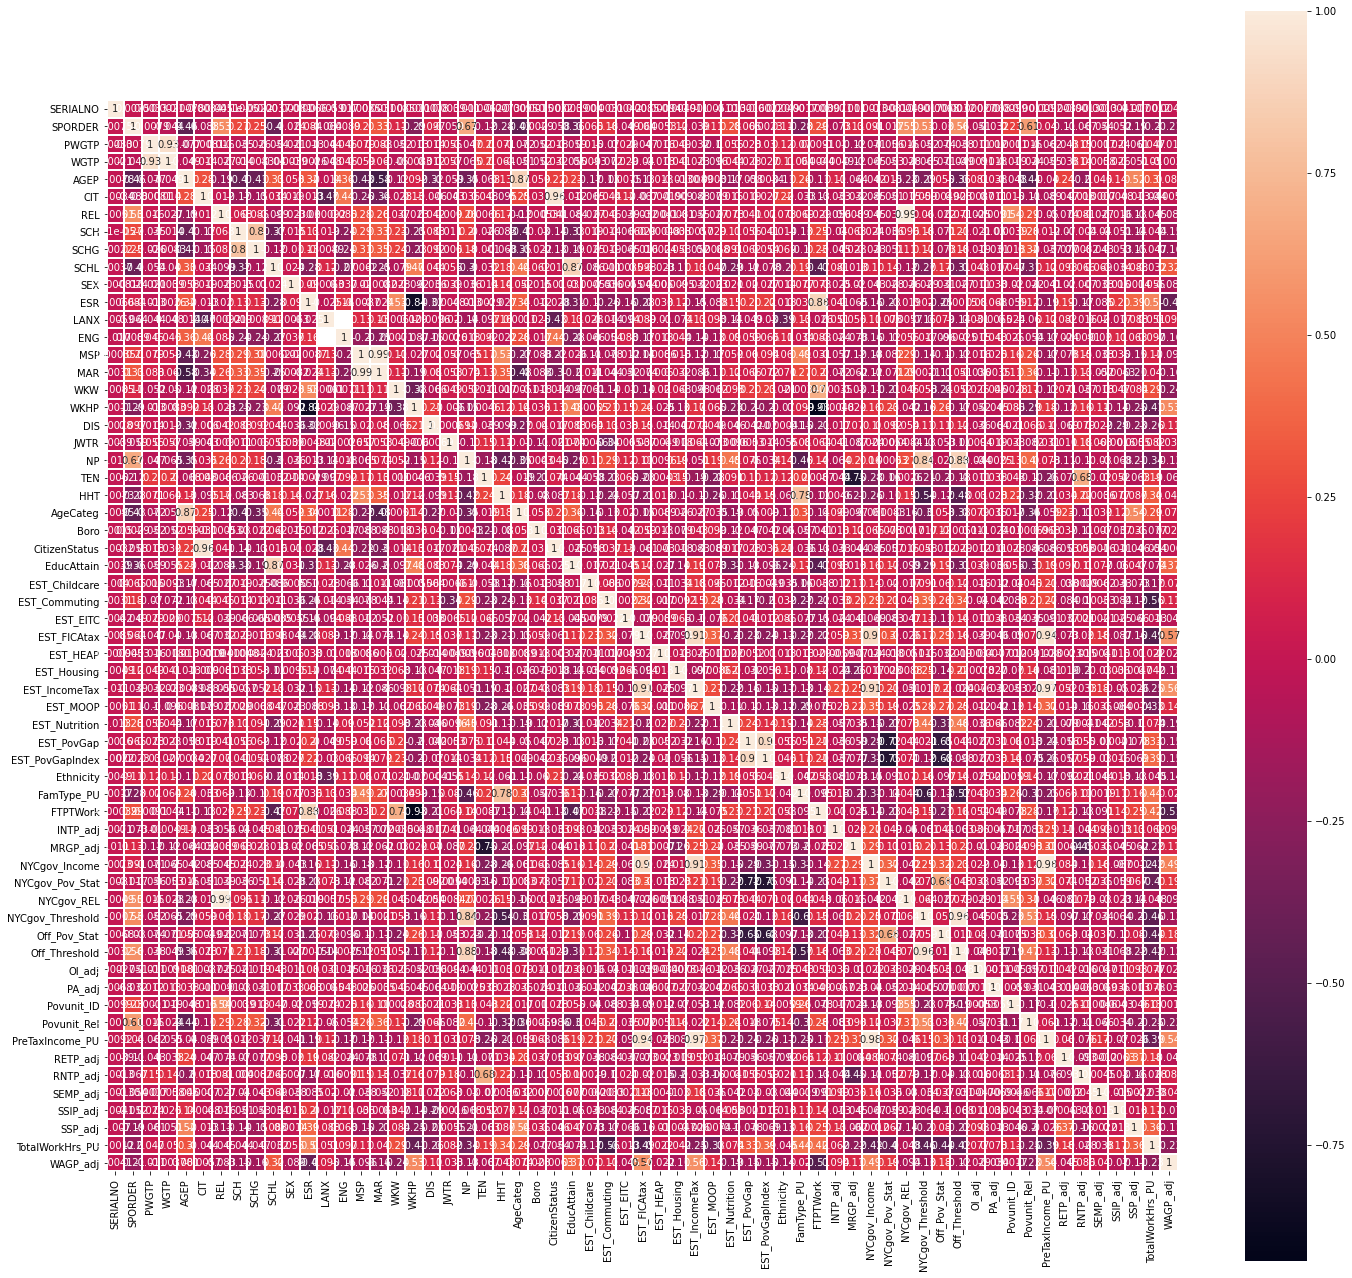

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(24,23))
sns.heatmap(dfPoverty.select([c for c in dfPoverty]).toPandas().corr(),linewidths=0.2,vmax=1.0, square=True, linecolor="white",annot=True)
display(plt.show())
plt.gcf().clear()

###Arrestos

In [0]:
dfdescribe = dfArrests.describe().toPandas().transpose()
dfdescribe

0 
 1 
 2 
 3 
 4 
 
 
 
 
 summary 
 count 
 mean 
 stddev 
 min 
 max 
 
 
 ARREST_KEY 
 93238 
 2.4309662364381474E8 
 2534191.4468695517 
 238492434 
 247417454 
 
 
 ARREST_DATE 
 93238 
 None 
 None 
 01/01/2022 
 06/30/2022 
 
 
 PD_CD 
 93005 
 405.432062792323 
 270.9641207405663 
 15 
 997 
 
 
 PD_DESC 
 93238 
 None 
 None 
 (null) 
 WEAPONS,MFR,TRANSPORT,ETC. 
 
 
 KY_CD 
 92934 
 247.76932016269612 
 151.5383269454767 
 101 
 995 
 
 
 OFNS_DESC 
 93238 
 None 
 None 
 (null) 
 VEHICLE AND TRAFFIC LAWS 
 
 
 LAW_CODE 
 93238 
 None 
 None 
 ABC0064A00 
 VTL1229C3A 
 
 
 LAW_CAT_CD 
 92327 
 9.0 
 0.0 
 9 
 V 
 
 
 ARREST_BORO 
 93238 
 None 
 None 
 Bronx 
 Staten Island 
 
 
 ARREST_PRECINCT 
 93238 
 62.91886355348677 
 35.042096252103 
 1 
 123 
 
 
 JURISDICTION_CODE 
 93238 
 0.965314571312126 
 8.108804742028518 
 0 
 97 
 
 
 AGE_GROUP 
 93238 
 None 
 None 
 18-24 
 <18 
 
 
 PERP_SEX 
 93238 
 None 
 None 
 F 
 M 
 
 
 PERP_RACE 
 93238 
 None 
 None 
 AMERICAN INDIAN/ALASKAN NATIVE 
 WHITE HISPANIC 
 
 
 X_COORD_CD 
 93238 
 1004902.6781140737 
 21244.459079788277 
 914617 
 1067185 
 
 
 Y_COORD_CD 
 93238 
 208473.04543211995 
 29546.933230291947 
 121545 
 271819 
 
 
 Latitude 
 93238 
 40.73883998037525 
 0.08110350521312874 
 40.500044 
 40.912714 
 
 
 Longitude 
 93238 
 -73.92544494824938 
 0.07661784395725489 
 -74.250422 
 -73.700717 
 
 
 New Georeferenced Column 
 93238 
 None 
 None 
 POINT (-73.700717 40.739959) 
 POINT (-74.250422 40.512739)

In [0]:
for i in dfArrests.columns:
  if not( isinstance(dfArrests.select(i).take(1)[0][0], six.string_types)):
    print( i, "Su correlación con PD_CD es:", dfArrests.stat.corr('PD_CD', i))

ARREST_KEY Su correlación con PD_CD es: -0.007908422967661328
PD_CD Su correlación con PD_CD es: 1.0
KY_CD Su correlación con PD_CD es: 0.028337107214968106
ARREST_PRECINCT Su correlación con PD_CD es: 0.06558393450304337
JURISDICTION_CODE Su correlación con PD_CD es: 0.006893030854828706
X_COORD_CD Su correlación con PD_CD es: -0.029245127697133125
Y_COORD_CD Su correlación con PD_CD es: -0.06561107094147237
Latitude Su correlación con PD_CD es: -0.0656232815833863
Longitude Su correlación con PD_CD es: -0.02927743452985653


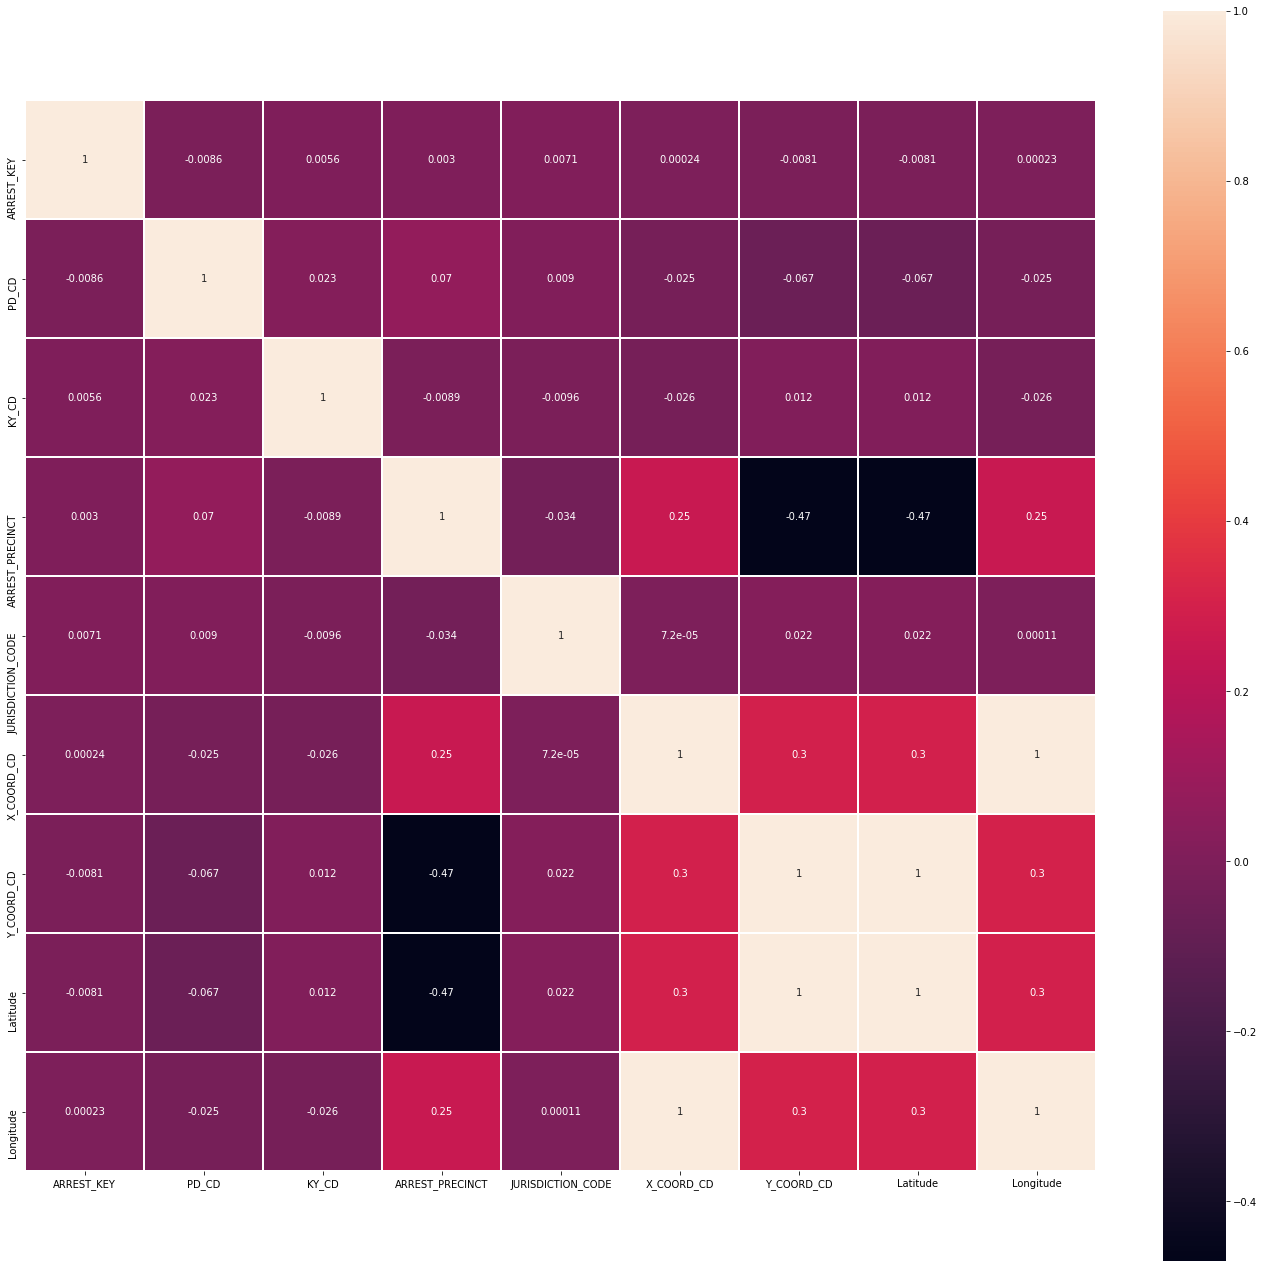

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(24,23))
sns.heatmap(dfArrests.select([c for c in dfArrests]).toPandas().corr(),linewidths=0.2,vmax=1.0, square=True, linecolor="white",annot=True)
display(plt.show())
plt.gcf().clear()

###Población

In [0]:
dfdescribe = dfPopulation.describe().toPandas().transpose()
dfdescribe

0 
 1 
 2 
 3 
 4 
 
 
 
 
 summary 
 count 
 mean 
 stddev 
 min 
 max 
 
 
 Age Group 
 6 
 None 
 None 
 Total Population 
 Total Population 
 
 
 Borough 
 6 
 None 
 None 
 Bronx 
 NYC Total 
 
 
 1950 
 6 
 2630652.3333333335 
 2707346.458323993 
 191555 
 7891957 
 
 
 1950 - Boro share of NYC total 
 6 
 33.335 
 34.30452375416397 
 2.43 
 100.0 
 
 
 1960 
 6 
 2593994.6666666665 
 2658094.7613355448 
 221991 
 7781984 
 
 
 1960 - Boro share of NYC total 
 6 
 33.33166666666666 
 34.1578426816839 
 2.85 
 100.0 
 
 
 1970 
 6 
 2631620.6666666665 
 2687573.331296965 
 295443 
 7894862 
 
 
 1970 - Boro share of NYC total 
 6 
 33.333333333333336 
 34.042349311800834 
 3.74 
 100.0 
 
 
 1980 
 6 
 2357213.0 
 2398083.72875002 
 352121 
 7071639 
 
 
 1980 - Boro share of NYC total 
 6 
 33.335 
 33.91080344079155 
 4.98 
 100.0 
 
 
 1990 
 6 
 2440854.6666666665 
 2481152.91669866 
 378977 
 7322564 
 
 
 1990 - Boro share of NYC total 
 6 
 33.333333333333336 
 33.883253484083646 
 5.18 
 100.0 
 
 
 2000 
 6 
 2669426.0 
 2711504.657892145 
 443728 
 8008278 
 
 
 2000 - Boro share of NYC total 
 6 
 33.333333333333336 
 33.85861347820768 
 5.54 
 100.0 
 
 
 2010 
 6 
 2747541.3333333335 
 2788549.403031739 
 468730 
 8242624 
 
 
 2010 - Boro share of NYC total 
 6 
 33.333333333333336 
 33.83063089371327 
 5.69 
 100.0 
 
 
 2020 
 6 
 2850323.6666666665 
 2892476.0307922806 
 487155 
 8550971 
 
 
 2020 - Boro share of NYC total 
 6 
 33.33333333333333 
 33.825785233556175 
 5.7 
 100.0 
 
 
 2030 
 6 
 2940342.3333333335 
 2984012.3318332094 
 497749 
 8821027 
 
 
 2030 - Boro share of NYC total 
 6 
 33.33333333333333 
 33.82865038198637 
 5.64 
 100.0 
 
 
 2040 
 6 
 3008381.6666666665 
 3054414.2254916676 
 501109 
 9025145 
 
 
 2040 - Boro share of NYC total 
 6 
 33.33166666666667 
 33.8440360575784 
 5.55 
 100.0

In [0]:
for i in dfPopulation.columns:
  if not( isinstance(dfPopulation.select(i).take(1)[0][0], six.string_types)):
    print( i, "Su correlación con 2010 - Boro share of NYC total  es:", dfPopulation.stat.corr('2010 - Boro share of NYC total', i))

1950 Su correlación con 2010 - Boro share of NYC total  es: 0.9900257750530299
1950 - Boro share of NYC total Su correlación con 2010 - Boro share of NYC total  es: 0.9900194871591182
1960 Su correlación con 2010 - Boro share of NYC total  es: 0.9964834014354708
1960 - Boro share of NYC total Su correlación con 2010 - Boro share of NYC total  es: 0.9964820006022908
1970 Su correlación con 2010 - Boro share of NYC total  es: 0.9986495606720207
1970 - Boro share of NYC total Su correlación con 2010 - Boro share of NYC total  es: 0.9986479442558672
1980 Su correlación con 2010 - Boro share of NYC total  es: 0.9998166727653282
1980 - Boro share of NYC total Su correlación con 2010 - Boro share of NYC total  es: 0.9998164834960659
1990 Su correlación con 2010 - Boro share of NYC total  es: 0.9998118645887798
1990 - Boro share of NYC total Su correlación con 2010 - Boro share of NYC total  es: 0.9998128090739106
2000 Su correlación con 2010 - Boro share of NYC total  es: 0.999967712003069
20

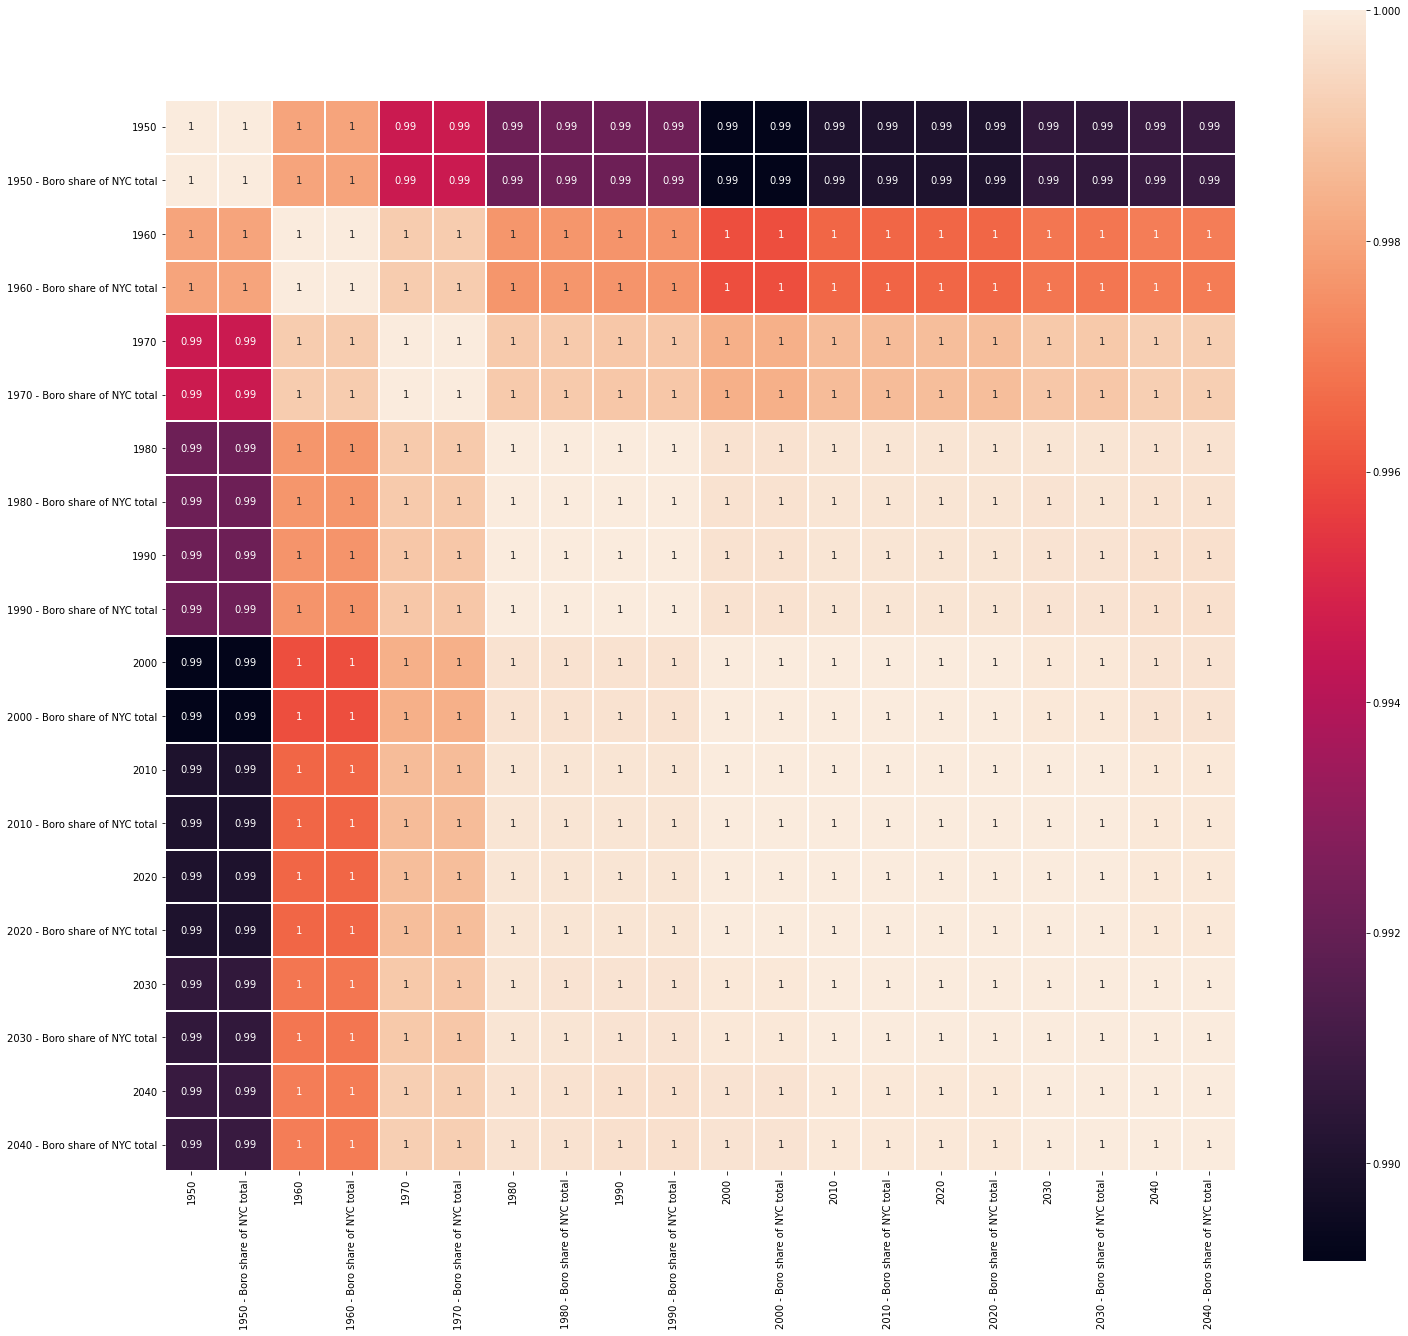

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(24,23))
sns.heatmap(dfPopulation.select([c for c in dfPopulation]).toPandas().corr(),linewidths=0.2,vmax=1.0, square=True, linecolor="white",annot=True)
display(plt.show())
plt.gcf().clear()

#Kmeans

In [0]:
#Librerias

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [0]:
display(dfArrestsDate)

ARREST_KEY ARREST_DATE PD_CD PD_DESC KY_CD OFNS_DESC LAW_CODE LAW_CAT_CD ARREST_BORO ARREST_PRECINCT JURISDICTION_CODE AGE_GROUP PERP_SEX PERP_RACE X_COORD_CD Y_COORD_CD Latitude Longitude New Georeferenced Column month day year 239406147 01/20/2022 null (null) null (null) CPL5700600 9 Queens 113 3 25-44 M BLACK 1046367 186986 40.67970059 -73.77604735 POINT (-73.77604735 40.67970059) 01 20 2022 239828064 01/28/2022 null (null) null (null) CPL5700600 9 Queens 113 3 45-64 M BLACK 1046367 186986 40.67970059 -73.77604735 POINT (-73.77604735 40.67970059) 01 28 2022 241020842 02/21/2022 null (null) null (null) CPL5700600 9 Queens 102 0 25-44 M BLACK 1032501 198800 40.712206 -73.825952 POINT (-73.825952 40.712206) 02 21 2022 240475883 02/11/2022 157 RAPE 1 104 RAPE PL 1303501 F Bronx 50 0 25-44 M BLACK 1010914 260940 40.8828621313214 -73.9035744897024 POINT (-73.9035744897024 40.8828621313214) 02 11 2022 241818674 03/09/2022 null (null) null (null) CPL5700600 9 Queens 114 0 18-24 F BLACK 1007694 219656 40.769552 -73.915361 POINT (-73.915361 40.769552) 03 09 2022 243189844 04/07/2022 null (null) null (null) CPL5700600 9 Queens 105 0 25-44 M BLACK 1057766 203992 40.726284 -73.73476 POINT (-73.73476 40.726284) 04 07 2022 242181223 03/16/2022 null (null) null (null) CPL5700600 9 Queens 102 0 25-44 F BLACK 1031727 199223 40.713373 -73.82874 POINT (-73.82874 40.713373) 03 16 2022 242520065 03/23/2022 null (null) null (null) CPL5700600 9 Queens 102 72 25-44 M WHITE HISPANIC 1032501 198800 40.712206 -73.825952 POINT (-73.825952 40.712206) 03 23 2022 244307669 04/27/2022 579 (null) null (null) PL 2224002 F Staten Island 120 0 25-44 M WHITE 966190 160182 40.606321 -74.065039 POINT (-74.065039 40.606321) 04 27 2022 242479164 03/22/2022 263 ARSON 2,3,4 114 ARSON PL 1501001 F Staten Island 122 71 25-44 M WHITE 958052 148351 40.573828 -74.094302 POINT (-74.094302 40.573828) 03 22 2022 244095058 04/24/2022 null (null) null (null) CPL5700600 9 Queens 102 0 25-44 M BLACK 1032501 198800 40.712206 -73.825952 POINT (-73.825952 40.712206) 04 24 2022 243091114 04/04/2022 null (null) null (null) CPL5700600 9 Queens 113 3 45-64 M BLACK 1046315 187088 40.6799807384666 -73.7762339071953 POINT (-73.7762339071953 40.6799807384666) 04 04 2022 243871620 04/19/2022 578 (null) null (null) PL 2223001 M Queens 101 0 18-24 M BLACK 1053639 158980 40.6027762300781 -73.7501173648331 POINT (-73.7501173648331 40.6027762300781) 04 19 2022 244368711 04/29/2022 null (null) null (null) CPL5700600 9 Brooklyn 75 11 45-64 F BLACK 1012761 160687 40.607681 -73.897318 POINT (-73.897318 40.607681) 04 29 2022 244497058 05/03/2022 153 RAPE 3 104 RAPE PL 1302501 F Bronx 47 2 18-24 M BLACK 1026480 262584 40.8873136344706 -73.8472717577564 POINT (-73.8472717577564 40.8873136344706) 05 03 2022 245139396 05/16/2022 579 (null) null (null) PL 2223501 F Manhattan 23 1 25-44 M BLACK 1000328 225433 40.785423 -73.941939 POINT (-73.941939 40.785423) 05 16 2022 245277361 05/19/2022 null (null) null (null) CPL5700600 9 Queens 113 3 25-44 M BLACK 1046315 187088 40.6799807384666 -73.7762339071953 POINT (-73.7762339071953 40.6799807384666) 05 19 2022 245384390 05/20/2022 null (null) null (null) CPL5700600 9 Queens 107 0 25-44 M WHITE HISPANIC 1036628 204948 40.729059 -73.811018 POINT (-73.811018 40.729059) 05 20 2022 245961116 06/02/2022 null (null) null (null) CPL5700600 9 Bronx 52 11 18-24 M BLACK 1009403 253761 40.86315413 -73.90906434 POINT (-73.90906434 40.86315413) 06 02 2022 246247820 06/08/2022 null (null) null (null) CPL5700600 9 Queens 113 0 18-24 M BLACK 1040791 190159 40.688439 -73.796122 POINT (-73.796122 40.688439) 06 08 2022 245711809 05/26/2022 null (null) null (null) CPL5700600 9 Manhattan 10 3 18-24 M BLACK 984791 209846 40.7426636084461 -73.9980491084798 POINT (-73.9980491084798 40.7426636084461) 05 26 2022 241716591 03/07/2022 397 ROBBERY,OPEN AREA UNCLASSIFIED 105 ROBBERY PL 1600500 F Brooklyn 69 0 25-44 M BLACK 1016255 168574 40.629316 -73.884696 POINT (-73.884696 40.629316) 03 07

In [0]:
from pyspark.sql.functions import col
dfArrestDemog = dfArrestsDate.select(col("AGE_GROUP"),col("PERP_SEX"),col("PERP_RACE"))
display(dfArrestDemog)

AGE_GROUP PERP_SEX PERP_RACE 25-44 M BLACK 45-64 M BLACK 25-44 M BLACK 25-44 M BLACK 18-24 F BLACK 25-44 M BLACK 25-44 F BLACK 25-44 M WHITE HISPANIC 25-44 M WHITE 25-44 M WHITE 25-44 M BLACK 45-64 M BLACK 18-24 M BLACK 45-64 F BLACK 18-24 M BLACK 25-44 M BLACK 25-44 M BLACK 25-44 M WHITE HISPANIC 18-24 M BLACK 18-24 M BLACK 18-24 M BLACK 25-44 M BLACK 18-24 F BLACK 45-64 M BLACK 25-44 M WHITE 25-44 M WHITE HISPANIC 45-64 M BLACK 65+ M WHITE 25-44 F WHITE HISPANIC 65+ F BLACK 45-64 M WHITE 25-44 M BLACK 25-44 M ASIAN / PACIFIC ISLANDER 25-44 M BLACK 45-64 M WHITE HISPANIC 45-64 M BLACK 25-44 M AMERICAN INDIAN/ALASKAN NATIVE 18-24 M BLACK 45-64 M ASIAN / PACIFIC ISLANDER 45-64 M BLACK 25-44 M BLACK HISPANIC 18-24 M BLACK 18-24 M BLACK 45-64 M BLACK 45-64 M BLACK 25-44 M WHITE HISPANIC 18-24 M BLACK 18-24 M BLACK 45-64 M BLACK 25-44 F WHITE HISPANIC 18-24 M BLACK 45-64 M WHITE 25-44 M BLACK 18-24 M BLACK 25-44 M WHITE HISPANIC 25-44 F BLACK 25-44 M ASIAN / PACIFIC ISLANDER 25-44 M BLACK 25-44 M WHITE 45-64 M BLACK 25-44 M WHITE HISPANIC 25-44 M WHITE HISPANIC 25-44 M BLACK <18 M ASIAN / PACIFIC ISLANDER 18-24 M BLACK HISPANIC 45-64 M BLACK 25-44 M ASIAN / PACIFIC ISLANDER 25-44 F WHITE HISPANIC 18-24 M BLACK HISPANIC 65+ M WHITE HISPANIC 45-64 M BLACK 25-44 M BLACK HISPANIC 18-24 M BLACK HISPANIC 25-44 M BLACK 25-44 M ASIAN / PACIFIC ISLANDER 25-44 M WHITE HISPANIC 25-44 M BLACK 25-44 M BLACK 25-44 M WHITE 45-64 M BLACK 45-64 M WHITE 25-44 M BLACK 25-44 M BLACK HISPANIC 25-44 M BLACK 25-44 M BLACK 18-24 M BLACK 25-44 M BLACK 25-44 F BLACK 45-64 M BLACK 25-44 M BLACK HISPANIC 25-44 M BLACK 25-44 M WHITE HISPANIC 25-44 M BLACK HISPANIC <18 M WHITE HISPANIC 45-64 F BLACK 25-44 M BLACK 45-64 M WHITE 25-44 F BLACK HISPANIC 45-64 M ASIAN / PACIFIC ISLANDER 18-24 F BLACK 25-44 M WHITE HISPANIC 25-44 M WHITE HISPANIC 45-64 M WHITE HISPANIC 25-44 F WHITE HISPANIC 25-44 M BLACK 18-24 M BLACK 25-44 F BLACK 18-24 M WHITE 25-44 M BLACK 25-44 M WHITE HISPANIC 25-44 M BLACK 25-44 F BLACK 25-44 M BLACK 25-44 M WHITE HISPANIC 25-44 M BLACK 45-64 F BLACK HISPANIC 25-44 F WHITE 25-44 F WHITE HISPANIC 18-24 F BLACK 25-44 M WHITE HISPANIC 25-44 M BLACK 25-44 F WHITE HISPANIC 18-24 M WHITE HISPANIC 25-44 M WHITE HISPANIC 25-44 M WHITE HISPANIC 25-44 M BLACK 25-44 M BLACK 25-44 F ASIAN / PACIFIC ISLANDER 25-44 M BLACK HISPANIC 18-24 M WHITE 45-64 M BLACK 18-24 F WHITE HISPANIC 45-64 M BLACK 25-44 M BLACK 25-44 M BLACK 45-64 M BLACK 25-44 F BLACK 25-44 M BLACK HISPANIC 45-64 M WHITE HISPANIC 45-64 F BLACK 25-44 F WHITE HISPANIC 25-44 F BLACK 25-44 M BLACK 45-64 M WHITE HISPANIC 25-44 M BLACK 25-44 M BLACK 25-44 M BLACK 25-44 M WHITE HISPANIC 25-44 M BLACK 25-44 F BLACK 25-44 M WHITE HISPANIC <18 M BLACK 18-24 F WHITE HISPANIC 18-24 F BLACK 45-64 F BLACK 45-64 M BLACK 25-44 M WHITE 18-24 M BLACK 25-44 F BLACK 45-64 M WHITE HISPANIC 25-44 F WHITE 18-24 M BLACK 65+ M WHITE HISPANIC 25-44 M WHITE 18-24 M BLACK 25-44 F BLACK 25-44 M WHITE HISPANIC 25-44 M BLACK 18-24 M BLACK 18-24 M WHITE HISPANIC 25-44 M WHITE HISPANIC 25-44 M BLACK 25-44 M WHITE HISPANIC 25-44 M BLACK 25-44 F WHITE HISPANIC 25-44 M BLACK HISPANIC 45-64 M BLACK 18-24 M WHITE <18 M BLACK 18-24 F ASIAN / PACIFIC ISLANDER 25-44 M WHITE HISPANIC 25-44 M BLACK 18-24 M WHITE 25-44 M BLACK 25-44 M WHITE HISPANIC 45-64 M BLACK 18-24 F WHITE HISPANIC 45-64 M ASIAN / PACIFIC ISLANDER 25-44 M BLACK 18-24 M BLACK 18-24 M BLACK 25-44 M BLACK 25-44 F BLACK HISPANIC 25-44 M BLACK 25-44 M BLACK 45-64 M BLACK 45-64 M BLACK 25-44 M WHITE 25-44 M BLACK 45-64 M WHITE HISPANIC 25-44 M BLACK HISPANIC 25-44 M BLACK 25-44 M BLACK 18-24 M BLACK 25-44 M BLACK 25-44 M BLACK 25-44 F BLACK 45-64 F BLACK 25-44 M WHITE HISPANIC 25-44 M BLACK HISPANIC 45-64 M WHITE HISPANIC 25-44 M ASIAN / PACIFIC ISLANDER 25-44 F WHITE 25-44 M BLACK 25-44 F BLACK 18-24 F BLACK 18-24 M ASIAN / PACIFIC ISLANDER 18-24 M WHITE HISPANIC 25-44 M BLACK 45-64 M BLACK 25-44 M BLACK 45-64 M WHITE HISPANIC 25-44 F WHITE HISPANIC 25-44 M BLACK 25-4

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline


indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(dfArrestDemog) for column in list(set(dfArrestDemog.columns)-set(['date'])) ]


pipeline = Pipeline(stages=indexers)
dfArrestDemog = pipeline.fit(dfArrestDemog).transform(dfArrestDemog)

display(dfArrestDemog)

AGE_GROUP PERP_SEX PERP_RACE AGE_GROUP_index PERP_RACE_index PERP_SEX_index 25-44 M BLACK 0.0 0.0 0.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 18-24 F BLACK 2.0 0.0 1.0 25-44 M BLACK 0.0 0.0 0.0 25-44 F BLACK 0.0 0.0 1.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M WHITE 0.0 2.0 0.0 25-44 M WHITE 0.0 2.0 0.0 25-44 M BLACK 0.0 0.0 0.0 45-64 M BLACK 1.0 0.0 0.0 18-24 M BLACK 2.0 0.0 0.0 45-64 F BLACK 1.0 0.0 1.0 18-24 M BLACK 2.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 18-24 M BLACK 2.0 0.0 0.0 18-24 M BLACK 2.0 0.0 0.0 18-24 M BLACK 2.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 18-24 F BLACK 2.0 0.0 1.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M WHITE 0.0 2.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 45-64 M BLACK 1.0 0.0 0.0 65+ M WHITE 4.0 2.0 0.0 25-44 F WHITE HISPANIC 0.0 1.0 1.0 65+ F BLACK 4.0 0.0 1.0 45-64 M WHITE 1.0 2.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M ASIAN / PACIFIC ISLANDER 0.0 4.0 0.0 25-44 M BLACK 0.0 0.0 0.0 45-64 M WHITE HISPANIC 1.0 1.0 0.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M AMERICAN INDIAN/ALASKAN NATIVE 0.0 6.0 0.0 18-24 M BLACK 2.0 0.0 0.0 45-64 M ASIAN / PACIFIC ISLANDER 1.0 4.0 0.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M BLACK HISPANIC 0.0 3.0 0.0 18-24 M BLACK 2.0 0.0 0.0 18-24 M BLACK 2.0 0.0 0.0 45-64 M BLACK 1.0 0.0 0.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 18-24 M BLACK 2.0 0.0 0.0 18-24 M BLACK 2.0 0.0 0.0 45-64 M BLACK 1.0 0.0 0.0 25-44 F WHITE HISPANIC 0.0 1.0 1.0 18-24 M BLACK 2.0 0.0 0.0 45-64 M WHITE 1.0 2.0 0.0 25-44 M BLACK 0.0 0.0 0.0 18-24 M BLACK 2.0 0.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 F BLACK 0.0 0.0 1.0 25-44 M ASIAN / PACIFIC ISLANDER 0.0 4.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M WHITE 0.0 2.0 0.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M BLACK 0.0 0.0 0.0 <18 M ASIAN / PACIFIC ISLANDER 3.0 4.0 0.0 18-24 M BLACK HISPANIC 2.0 3.0 0.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M ASIAN / PACIFIC ISLANDER 0.0 4.0 0.0 25-44 F WHITE HISPANIC 0.0 1.0 1.0 18-24 M BLACK HISPANIC 2.0 3.0 0.0 65+ M WHITE HISPANIC 4.0 1.0 0.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M BLACK HISPANIC 0.0 3.0 0.0 18-24 M BLACK HISPANIC 2.0 3.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M ASIAN / PACIFIC ISLANDER 0.0 4.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M WHITE 0.0 2.0 0.0 45-64 M BLACK 1.0 0.0 0.0 45-64 M WHITE 1.0 2.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M BLACK HISPANIC 0.0 3.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 18-24 M BLACK 2.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 F BLACK 0.0 0.0 1.0 45-64 M BLACK 1.0 0.0 0.0 25-44 M BLACK HISPANIC 0.0 3.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M BLACK HISPANIC 0.0 3.0 0.0 <18 M WHITE HISPANIC 3.0 1.0 0.0 45-64 F BLACK 1.0 0.0 1.0 25-44 M BLACK 0.0 0.0 0.0 45-64 M WHITE 1.0 2.0 0.0 25-44 F BLACK HISPANIC 0.0 3.0 1.0 45-64 M ASIAN / PACIFIC ISLANDER 1.0 4.0 0.0 18-24 F BLACK 2.0 0.0 1.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 45-64 M WHITE HISPANIC 1.0 1.0 0.0 25-44 F WHITE HISPANIC 0.0 1.0 1.0 25-44 M BLACK 0.0 0.0 0.0 18-24 M BLACK 2.0 0.0 0.0 25-44 F BLACK 0.0 0.0 1.0 18-24 M WHITE 2.0 2.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 F BLACK 0.0 0.0 1.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M BLACK 0.0 0.0 0.0 45-64 F BLACK HISPANIC 1.0 3.0 1.0 25-44 F WHITE 0.0 2.0 1.0 25-44 F WHITE HISPANIC 0.0 1.0 1.0 18-24 F BLACK 2.0 0.0 1.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 F WHITE HISPANIC 0.0 1.0 1.0 18-24 M WHITE HISPANIC 2.0 1.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 M BLACK 0.0 0.0 0.0 25-44 F ASIAN / PACIFIC ISLANDER 0.0 4.0 1.0 25-44 M BLACK HISPANIC 0.0 3.0 0.0 18-24 M WHITE 2.0 2.0 0.0 45-64 M BLACK 1.0 0.0 0.0 18-24 F W

In [0]:
assemble=VectorAssembler(inputCols=[
 'AGE_GROUP_index',
 'PERP_SEX_index',
 'PERP_RACE_index'
], outputCol='features')
dfArrestsAssemble=assemble.transform(dfArrestDemog)
display(dfArrestsAssemble)


AGE_GROUP PERP_SEX PERP_RACE AGE_GROUP_index PERP_RACE_index PERP_SEX_index features 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 18-24 F BLACK 2.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0)) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 25-44 F BLACK 0.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 45-64 F BLACK 1.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 1.0, 0.0)) 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 18-24 F BLACK 2.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0)) 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 65+ M WHITE 4.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(4.0, 0.0, 2.0)) 25-44 F WHITE HISPANIC 0.0 1.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 1.0)) 65+ F BLACK 4.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(4.0, 1.0, 0.0)) 45-64 M WHITE 1.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 2.0)) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 25-44 M ASIAN / PACIFIC ISLANDER 0.0 4.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 4.0)) 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 45-64 M WHITE HISPANIC 1.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 1.0)) 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 25-44 M AMERICAN INDIAN/ALASKAN NATIVE 0.0 6.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 6.0)) 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 45-64 M ASIAN / PACIFIC ISLANDER 1.0 4.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 4.0)) 45-64 M BLACK 1.0 0.0 0.0 Map(vector

In [0]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dfArrestsAssemble)

In [0]:
predictions = model.transform(dfArrestsAssemble)
display(predictions)

AGE_GROUP PERP_SEX PERP_RACE AGE_GROUP_index PERP_RACE_index PERP_SEX_index features prediction 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 1 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 18-24 F BLACK 2.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0)) 0 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 25-44 F BLACK 0.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 1 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 1 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 1 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 1 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 1 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 0 45-64 F BLACK 1.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 1.0, 0.0)) 1 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 0 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 1 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 0 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 0 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 0 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 18-24 F BLACK 2.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0)) 0 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 1 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 1 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 1 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 1 65+ M WHITE 4.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(4.0, 0.0, 2.0)) 0 25-44 F WHITE HISPANIC 0.0 1.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 1.0)) 1 65+ F BLACK 4.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(4.0, 1.0, 0.0)) 0 45-64 M WHITE 1.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 2.0)) 1 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 25-44 M ASIAN / PACIFIC ISLANDER 0.0 4.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 4.0)) 1 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 1 45-64 M WHITE HISPANIC 1.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 1.0)) 1 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 1 25-44 M AMERICAN INDIAN/ALASKAN NATIVE 0.0 6.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 6.0)) 1 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 0 45-64 M ASIAN / PACIFIC ISLANDER 1.0 4.0 0.0 Map(vectorType -> 

In [0]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5267681974461154


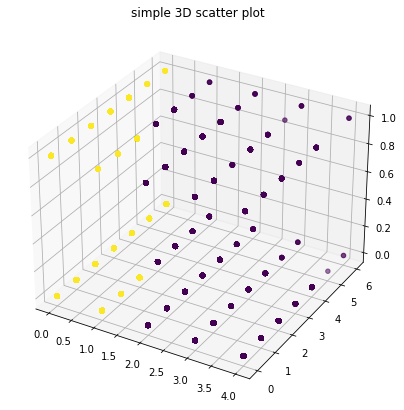

In [0]:

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
#colors = ['blue', 'green', 'red']



    

ax.scatter3D(predictions.select("AGE_GROUP_index").toPandas().values, predictions.select("PERP_RACE_index").toPandas().values, predictions.select("PERP_SEX_index").toPandas().values, c =predictions.select("prediction").toPandas().values)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

0 0.5267681974461154 0.6753112738473919 0.5346891553767291 0.5160935437524249 0.5657556803888971 0.529900759895806 0.5924759157634063 0.6071302344668646

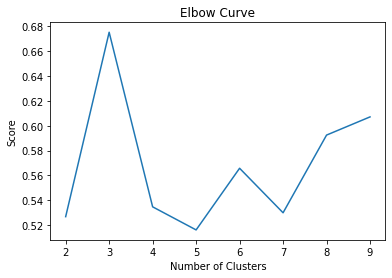

In [0]:
import numpy as np
import pandas as pd
silho = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(dfArrestsAssemble)
    predictions = model.transform(dfArrestsAssemble)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silho[k]=silhouette

# Plot the cost
df_silho = pd.DataFrame(silho[2:])
display(df_silho)
df_silho.columns = ["silho"]
new_col = [2,3,4,5,6,7,8, 9]
df_silho.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_silho.cluster, df_silho.silho)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

##Con k=6

In [0]:
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(dfArrestsAssemble)

In [0]:
predictions = model.transform(dfArrestsAssemble)
display(predictions)

AGE_GROUP PERP_SEX PERP_RACE AGE_GROUP_index PERP_RACE_index PERP_SEX_index features prediction 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 0 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 18-24 F BLACK 2.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0)) 4 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 25-44 F BLACK 0.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 3 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 5 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 2 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 2 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 0 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 4 45-64 F BLACK 1.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 1.0, 0.0)) 3 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 4 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 5 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 4 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 4 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 4 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 18-24 F BLACK 2.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 1.0, 0.0)) 4 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 0 25-44 M WHITE 0.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 2.0)) 2 25-44 M WHITE HISPANIC 0.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 5 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 0 65+ M WHITE 4.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(4.0, 0.0, 2.0)) 4 25-44 F WHITE HISPANIC 0.0 1.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 1.0)) 5 65+ F BLACK 4.0 0.0 1.0 Map(vectorType -> dense, length -> 3, values -> List(4.0, 1.0, 0.0)) 4 45-64 M WHITE 1.0 2.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 2.0)) 2 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 25-44 M ASIAN / PACIFIC ISLANDER 0.0 4.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 4.0)) 1 25-44 M BLACK 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 3, indices -> List(), values -> List()) 0 45-64 M WHITE HISPANIC 1.0 1.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 1.0)) 5 45-64 M BLACK 1.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(1.0, 0.0, 0.0)) 0 25-44 M AMERICAN INDIAN/ALASKAN NATIVE 0.0 6.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 6.0)) 1 18-24 M BLACK 2.0 0.0 0.0 Map(vectorType -> dense, length -> 3, values -> List(2.0, 0.0, 0.0)) 4 45-64 M ASIAN / PACIFIC ISLANDER 1.0 4.0 0.0 Map(vectorType -> 

In [0]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5657556803888971


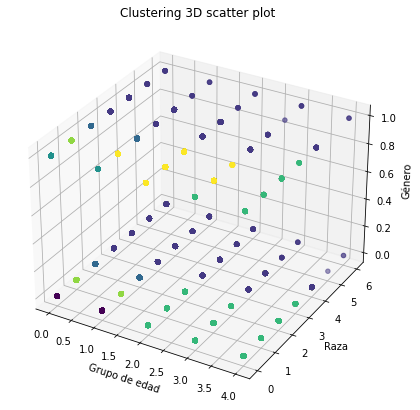

In [0]:

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
#colors = ['blue', 'green', 'red']



    

ax.scatter3D(predictions.select("AGE_GROUP_index").toPandas().values, predictions.select("PERP_RACE_index").toPandas().values, predictions.select("PERP_SEX_index").toPandas().values, c =predictions.select("prediction").toPandas().values)
plt.title("Clustering 3D scatter plot")
ax.set_xlabel('Grupo de edad')
ax.set_ylabel('Raza')
ax.set_zlabel("Género")
 
# show plot
plt.show()

#Con Poverty

In [0]:
dfPoverty.display()

SERIALNO SPORDER PWGTP WGTP AGEP CIT REL SCH SCHG SCHL SEX ESR LANX ENG MSP MAR WKW WKHP DIS JWTR NP TEN HHT AgeCateg Boro CitizenStatus EducAttain EST_Childcare EST_Commuting EST_EITC EST_FICAtax EST_HEAP EST_Housing EST_IncomeTax EST_MOOP EST_Nutrition EST_PovGap EST_PovGapIndex Ethnicity FamType_PU FTPTWork INTP_adj MRGP_adj NYCgov_Income NYCgov_Pov_Stat NYCgov_REL NYCgov_Threshold Off_Pov_Stat Off_Threshold OI_adj PA_adj Povunit_ID Povunit_Rel PreTaxIncome_PU RETP_adj RNTP_adj SEMP_adj SSIP_adj SSP_adj TotalWorkHrs_PU WAGP_adj 1 1 95 95 31 1 0 1 0 22 2 1 2 null 6 5 1 60 2 12 1 2 6 2 2 1 4 0.0 1722.0 0.0 9765.2422 0.0 1478.3278 33580.543 2642.8 0.0 0.0 0.0 4 8 1 0.0 0.0 81417.961 2 0 16241.6 2 13064 0.0 0.0 1 1 127650.22 0.0 0.0 0.0 0.0 0.0 2 127650.22 16 1 181 181 63 1 0 1 0 22 2 1 2 null 1 1 1 60 2 1 2 1 1 2 3 1 4 0.0 3840.8416 0.0 13950.346 0.0 0.0 95503.234 4766.7998 0.0 0.0 0.0 1 2 1 101309.7 2532.7424 228417.95 2 0 22900.654 2 16815 0.0 0.0 1 1 346479.19 0.0 0.0 0.0 0.0 0.0 2 182357.45 16 2 210 181 65 1 1 1 0 19 1 6 2 null 1 1 null 0 2 null 2 1 1 3 3 1 3 0.0 3840.8416 0.0 13950.346 0.0 0.0 95503.234 4766.7998 0.0 0.0 0.0 1 2 3 50654.852 2532.7424 228417.95 2 1 22900.654 2 16815 0.0 0.0 1 2 346479.19 0.0 0.0 0.0 0.0 12157.164 2 0.0 47 1 62 62 68 4 0 1 0 1 1 1 1 2 1 1 1 40 2 10 2 2 1 3 2 2 1 0.0 0.0 0.0 9765.2422 0.0 2612.8022 27574.365 3218.8 0.0 0.0 0.0 1 2 1 0.0 0.0 117058.23 2 0 22900.654 2 15178 0.0 0.0 1 1 155003.84 0.0 0.0 0.0 0.0 27353.619 1 91178.727 47 2 71 62 63 4 1 1 0 1 2 1 1 1 1 1 1 40 2 10 2 2 1 2 2 2 1 0.0 0.0 0.0 9765.2422 0.0 2612.8022 27574.365 3218.8 0.0 0.0 0.0 1 2 1 0.0 0.0 117058.23 2 1 22900.654 2 15178 0.0 0.0 1 2 155003.84 0.0 0.0 0.0 0.0 0.0 1 36471.492 55 1 430 430 29 5 0 1 0 21 2 6 1 3 1 1 1 40 2 null 3 3 1 2 4 3 4 0.0 4954.1665 0.0 2915.3896 0.0 0.0 1115.2131 0.0 0.0 3214.7793 0.14037937 4 2 1 0.0 0.0 19685.875 1 0 22900.654 2 16815 0.0 0.0 1 1 28670.645 0.0 2026.194 0.0 0.0 0.0 1 17526.578 55 2 466 430 25 5 1 1 0 21 1 1 1 1 1 1 1 40 2 1 3 3 1 2 4 3 4 0.0 4954.1665 0.0 2915.3896 0.0 0.0 1115.2131 0.0 0.0 3214.7793 0.14037937 4 2 1 0.0 0.0 19685.875 1 1 22900.654 2 16815 0.0 0.0 1 2 28670.645 0.0 2026.194 11144.067 0.0 0.0 1 0.0 55 3 453 430 32 1 15 1 0 16 1 1 1 1 6 5 1 40 2 1 3 3 1 2 4 1 2 0.0 6703.5 0.0 3875.0959 0.0 0.0 8213.8594 4176.96 0.0 0.0 0.0 4 7 1 0.0 0.0 27685.434 2 12 16241.6 2 13064 0.0 0.0 2 1 50654.852 0.0 2026.194 0.0 0.0 0.0 3 50654.852 194 1 201 201 76 4 0 1 0 21 1 6 2 null 3 2 null 0 2 null 1 3 4 3 2 2 4 0.0 0.0 0.0 0.0 0.0 0.0 1558.6013 1378.6801 0.0 0.0 0.0 2 8 3 405.2388 0.0 40727.199 2 0 16241.6 2 12043 0.0 0.0 1 1 43664.48 23402.541 891.52533 0.0 0.0 19856.701 5 0.0 218 1 55 56 46 5 0 1 0 17 2 1 1 4 1 1 1 35 2 4 2 3 1 2 2 3 2 0.0 1795.8 0.0 6122.6519 0.0 0.0 11775.876 9036.96 0.0 0.0 0.0 3 2 1 0.0 0.0 51303.375 2 0 22900.654 2 16815 0.0 0.0 1 1 80034.664 0.0 911.78729 0.0 0.0 0.0 2 70916.789 218 2 60 56 49 5 1 1 0 20 1 1 1 2 1 1 4 40 2 4 2 3 1 2 2 3 3 0.0 1795.8 0.0 6122.6519 0.0 0.0 11775.876 9036.96 0.0 0.0 0.0 3 2 2 0.0 0.0 51303.375 2 1 22900.654 2 16815 0.0 0.0 1 2 80034.664 0.0 911.78729 0.0 0.0 0.0 2 9117.873 398 1 119 119 61 4 0 1 0 13 1 1 2 null 1 1 1 40 2 4 2 3 1 2 3 2 1 0.0 1230.0 0.0 3100.0769 0.0 0.0 15641.518 7836.7598 0.0 0.0 0.0 5 2 1 0.0 0.0 84037.555 2 0 22900.654 2 16815 0.0 0.0 1 1 111845.91 0.0 1215.7164 0.0 0.0 0.0 3 40523.879 398 2 110 119 66 4 1 1 0 17 2 6 2 null 1 1 null 0 2 null 2 3 1 3 3 2 2 0.0 1230.0 0.0 3100.0769 0.0 0.0 15641.518 7836.7598 0.0 0.0 0.0 2 2 3 39004.234 0.0 84037.555 2 1 22900.654 2 16815 0.0 0.0 1 2 111845.91 13778.119 1215.7164 0.0 0.0 18539.676 3 0.0 414 1 53 53 49 1 0 1 0 19 2 1 2 null 1 1 1 40 2 4 3 1 1 2 3 1 3 0.0 3836.9167 0.0 7052.6748 0.0 0.0 12011.638 2036.0 0.0 0.0 0.0 2 1 1 0.0 202.6194 67254.602 2 0 30845.143 2 20212 0.0 0.0 1 1 92191.828 0.0 0.0 0.0 0.0 0.0 1 71929.891 414 2 101 53 49 4 1 1 0 1 1 1 2 null 1 1 1 40 1 1 3 1 1 2 3 2 1 0.0 3836.9167 0.0 7052.6748 0.0 0.0 12011.638 2036.0 0.0 0.0 0.0 2 1 1 0.0 202

In [0]:
dfPovertyDemog = dfPoverty.select(col("TEN"),col("CitizenStatus"),col("Ethnicity"),col("FamType_PU"),col("NYCgov_Pov_Stat"),col("TotalWorkHrs_PU"),col("CIT"),col("MAR"),col("RNTP_adj"))
display(dfPovertyDemog.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dfPovertyDemog.columns]))
display(dfPovertyDemog)
                                                 

TEN CitizenStatus Ethnicity FamType_PU NYCgov_Pov_Stat TotalWorkHrs_PU CIT MAR RNTP_adj 0 0 0 0 0 0 0 0 0

TEN CitizenStatus Ethnicity FamType_PU NYCgov_Pov_Stat TotalWorkHrs_PU CIT MAR RNTP_adj 2 1 4 8 2 2 1 5 0.0 1 1 1 2 2 2 1 1 0.0 1 1 1 2 2 2 1 1 0.0 2 2 1 2 2 1 4 1 0.0 2 2 1 2 2 1 4 1 0.0 3 3 4 2 1 1 5 1 2026.194 3 3 4 2 1 1 5 1 2026.194 3 1 4 7 2 3 1 5 2026.194 3 2 2 8 2 5 4 2 891.52533 3 3 3 2 2 2 5 1 911.78729 3 3 3 2 2 2 5 1 911.78729 3 2 5 2 2 3 4 1 1215.7164 3 2 2 2 2 3 4 1 1215.7164 1 1 2 1 2 1 1 1 0.0 1 2 2 1 2 1 4 1 0.0 1 1 2 1 2 1 1 5 0.0 3 3 1 1 2 3 5 1 1013.097 3 3 1 1 2 3 5 1 1013.097 3 1 1 1 2 3 1 5 1013.097 3 1 1 1 2 3 1 5 1013.097 1 1 1 1 1 3 1 1 0.0 1 1 1 1 1 3 1 1 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 1 1 1 1 1 3 1 5 0.0 3 2 2 4 2 3 4 5 111.44067 3 1 2 4 2 3 1 5 111.44067 3 1 1 2 2 2 1 5 607.85822 3 1 1 2 2 2 1 5 607.85822 1 2 4 2 2 5 4 1 0.0 1 2 4 2 2 5 4 1 0.0 1 1 4 2 2 5 1 5 0.0 1 1 4 7 1 4 1 1 0.0 3 3 4 1 2 2 5 1 1519.6455 3 3 4 1 2 2 5 1 1519.6455 3 1 4 1 2 2 1 5 1519.6455 3 1 4 1 2 2 1 5 1519.6455 3 1 4 1 2 2 1 5 1519.6455 1 1 2 1 2 2 1 1 0.0 1 1 2 1 2 2 1 1 0.0 1 1 2 1 2 2 1 5 0.0 1 1 2 1 2 2 1 5 0.0 3 1 4 8 2 5 1 5 253.27425 3 3 3 2 1 1 5 1 1924.8843 3 3 3 2 1 1 5 1 1924.8843 3 3 3 2 1 1 5 5 1924.8843 3 3 3 2 1 1 5 5 1924.8843 2 2 1 2 2 3 4 1 0.0 2 2 1 2 2 3 4 1 0.0 2 1 1 2 2 4 1 1 0.0 2 2 1 2 2 4 4 1 0.0 1 2 2 2 2 3 4 1 0.0 1 2 2 2 2 3 4 1 0.0 3 2 1 3 2 3 4 5 1722.2649 3 3 1 3 2 3 5 5 1722.2649 3 3 1 4 1 5 5 3 1722.2649 3 3 1 4 1 5 5 5 1722.2649 3 1 4 8 2 3 1 5 1317.0261 3 1 2 4 1 3 1 5 607.85822 3 1 2 4 1 3 1 5 607.85822 1 2 1 2 1 2 4 1 0.0 1 1 1 2 1 2 1 1 0.0 3 1 2 8 2 3 1 5 992.83508 2 1 1 2 2 5 1 3 0.0 2 1 1 2 2 5 1 3 0.0 3 1 1 8 2 3 1 5 1722.2649 2 1 4 2 2 1 1 1 0.0 2 1 4 2 2 1 1 1 0.0 2 1 2 7 2 3 1 1 0.0 1 1 1 8 2 3 1 2 0.0 2 2 3 2 2 1 4 1 0.0 2 3 3 2 2 1 5 1 0.0 2 1 3 2 2 1 1 1 0.0 2 1 3 2 2 1 1 5 0.0 2 3 4 5 2 1 5 2 0.0 2 3 4 5 2 1 5 5 0.0 2 1 4 7 1 4 1 5 0.0 1 1 1 1 2 1 1 1 0.0 1 1 1 1 2 1 1 1 0.0 1 1 1 1 2 1 3 5 0.0 1 1 1 1 2 1 3 5 0.0 1 1 1 1 2 1 3 5 0.0 1 1 1 1 2 1 3 5 0.0 1 2 1 1 2 1 4 1 0.0 1 2 1 1 2 1 4 1 0.0 1 2 1 1 2 1 4 5 0.0 1 1 1 1 2 1 1 5 0.0 1 1 1 1 2 1 1 5 0.0 1 2 2 8 2 3 4 5 0.0 3 1 2 2 2 1 1 1 1215.7164 3 2 4 2 2 1 4 1 1215.7164 3 1 2 2 2 1 1 5 1215.7164 2 1 1 8 1 5 1 2 0.0 3 1 1 1 2 1 1 1 2330.123 3 1 1 1 2 1 1 1 2330.123 3 1 1 1 2 1 1 5 2330.123 3 1 1 1 2 1 1 5 2330.123 3 3 4 2 2 1 5 1 1519.6455 3 3 4 2 2 1 5 1 1519.6455 3 3 4 2 2 1 5 5 1519.6455 3 3 4 2 2 1 5 5 1519.6455 3 1 2 1 2 3 1 1 303.92911 3 1 2 1 2 3 1 1 303.92911 3 1 2 1 2 3 1 5 303.92911 3 1 2 1 2 3 1 5 303.92911 3 2 4 7 1 5 4 3 992.83508 3 3 4 7 2 3 5 4 992.83508 1 1 1 2 2 5 1 1 0.0 1 1 1 2 2 5 1 1 0.0 2 1 1 8 1 4 1 3 0.0 1 1 1 8 2 3 1 5 0.0 3 2 3 1 2 1 4 1 1519.6455 3 1 1 1 2 1 1 1 1519.6455 3 1 5 1 2 1 1 5 1519.6455 1 1 1 8 2 3 1 5 0.0 2 2 2 8 2 5 4 3 0.0 2 2 3 2 1 5 4 1 0.0 2 2 3 2 1 5 4 1 0.0 2 2 3 2 1 5 4 5 0.0 3 1 4 1 2 1 1 1 1114.4067 3 3 4 1 2 1 5 1 1114.4067 3 1 4 1 2 1 1 5 1114.4067 2 2 2 2 2 3 4 1 0.0 2 2 2 2 2 3 4 1 0.0 1 3 2 2 2 1 5 1 0.0 1 2 2 2 2 1 4 1 0.0 1 1 2 2 2 1 1 5 0.0 1 1 2 2 2 1 1 5 0.0 1 1 4 8 1 5 1 3 0.0 3 1 1 2 2 2 1 1 2634.0522 3 1 1 2 2 2 1 1 2634.0522 3 1 4 6 1 5 2 5 800.34662 3 1 4 6 1 5 1 3 800.34662 1 1 2 2 2 1 1 1 0.0 1 2 2 2 2 1 4 1 0.0 1 1 2 2 2 1 1 5 0.0 1 1 2 2 2 1 1 5 0.0 3 1 1 8 2 3 1 5 1317.0261 3 1 2 2 2 1 1 1 709.16791 3 1 5 2 2 1 1 1 709.16791 3 3 4 1 2 1 5 1 1317.0261 3 3 4 1 2 1 5 1 1317.0261 3 1 4 1 2 1 1 5 1317.0261 3 1 4 1 2 1 1 5 1317.0261 3 1 1 8 2 3 1 5 2836.6716 3 1 1 1 2 1 1 1 1620.9552 3 1 1 1 2 1 1 1 1620.9552 3 1 1 1 2 1 1 5 1620.9552 3 1 1 1 2 1 1 5 1620.9552 3 1 1 1 2 1 1 5 1620.9552 3 1 1 1 2 1 1 5 1620.9552 3 1 1 1 2 1 1 5 1620.9552 1 2 1 4 2 4 4 2 0.0 1 1 1 4 2 4 1 5 0.0 1 1 1 4 2 4 1 5 0.0 1 1 1 4 2 4 1 5 0.0 3 2 4 1 2 3 4 1 668.64404 3 3 4 1 2 3 5 1 668.64404 3 1 4 1 2 3 1 5 668.64404 3 3 4 1 2 3 5 2 668.64404 2 2 3 2 2 4 4 1 0.0 2 2 3 2 2 4 4 1 0.0 3 2 1 5 2 1 4 5 2532.7424 3 2 1 5 2 1 4 5 2532.7424 3 2 1

In [0]:
assemble=VectorAssembler(inputCols=[
 'TEN',
 'CitizenStatus',
 'Ethnicity',
  'FamType_PU',
    'NYCgov_Pov_Stat',
    'TotalWorkHrs_PU',
    'CIT',
    'MAR',
    'RNTP_adj']
, outputCol='features')
dfPovAssemble=assemble.transform(dfPovertyDemog)
display(dfPovAssemble)


TEN CitizenStatus Ethnicity FamType_PU NYCgov_Pov_Stat TotalWorkHrs_PU CIT MAR RNTP_adj features 2 1 4 8 2 2 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 1.0, 4.0, 8.0, 2.0, 2.0, 1.0, 5.0, 0.0)) 1 1 1 2 2 2 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0)) 1 1 1 2 2 2 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0)) 2 2 1 2 2 1 4 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0)) 2 2 1 2 2 1 4 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0)) 3 3 4 2 1 1 5 1 2026.194 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 4.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2026.194)) 3 3 4 2 1 1 5 1 2026.194 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 4.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2026.194)) 3 1 4 7 2 3 1 5 2026.194 Map(vectorType -> dense, length -> 9, values -> List(3.0, 1.0, 4.0, 7.0, 2.0, 3.0, 1.0, 5.0, 2026.194)) 3 2 2 8 2 5 4 2 891.52533 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 2.0, 8.0, 2.0, 5.0, 4.0, 2.0, 891.52533)) 3 3 3 2 2 2 5 1 911.78729 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 5.0, 1.0, 911.78729)) 3 3 3 2 2 2 5 1 911.78729 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 5.0, 1.0, 911.78729)) 3 2 5 2 2 3 4 1 1215.7164 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 5.0, 2.0, 2.0, 3.0, 4.0, 1.0, 1215.7164)) 3 2 2 2 2 3 4 1 1215.7164 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 1.0, 1215.7164)) 1 1 2 1 2 1 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0)) 1 2 2 1 2 1 4 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 4.0, 1.0, 0.0)) 1 1 2 1 2 1 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 5.0, 0.0)) 3 3 1 1 2 3 5 1 1013.097 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 1.0, 1.0, 2.0, 3.0, 5.0, 1.0, 1013.097)) 3 3 1 1 2 3 5 1 1013.097 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 1.0, 1.0, 2.0, 3.0, 5.0, 1.0, 1013.097)) 3 1 1 1 2 3 1 5 1013.097 Map(vectorType -> dense, length -> 9, values -> List(3.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 5.0, 1013.097)) 3 1 1 1 2 3 1 5 1013.097 Map(vectorType -> dense, length -> 9, values -> List(3.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 5.0, 1013.097)) 1 1 1 1 1 3 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 0.0)) 1 1 1 1 1 3 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1

0 0.797268482005341 0.8487156016741018 0.8377414733593608 0.824690063223422 0.8196652122219158 0.8255826771031156 0.8218863029849081 0.8345041479206948

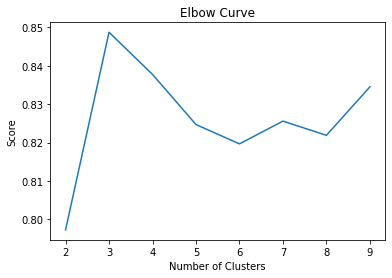

In [0]:
import numpy as np
import pandas as pd
silho = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(dfPovAssemble)
    predictions = model.transform(dfPovAssemble)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silho[k]=silhouette

# Plot the cost
df_silho = pd.DataFrame(silho[2:])
display(df_silho)
df_silho.columns = ["silho"]
new_col = [2,3,4,5,6,7,8, 9]
df_silho.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_silho.cluster, df_silho.silho)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

##Con k = 7

In [0]:
kmeans = KMeans().setK(7).setSeed(1)
model = kmeans.fit(dfPovAssemble)

In [0]:
predictions = model.transform(dfPovAssemble)
display(predictions)

TEN CitizenStatus Ethnicity FamType_PU NYCgov_Pov_Stat TotalWorkHrs_PU CIT MAR RNTP_adj features prediction 2 1 4 8 2 2 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 1.0, 4.0, 8.0, 2.0, 2.0, 1.0, 5.0, 0.0)) 1 1 1 1 2 2 2 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0)) 1 1 1 1 2 2 2 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0)) 1 2 2 1 2 2 1 4 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0)) 1 2 2 1 2 2 1 4 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 0.0)) 1 3 3 4 2 1 1 5 1 2026.194 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 4.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2026.194)) 2 3 3 4 2 1 1 5 1 2026.194 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 4.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2026.194)) 2 3 1 4 7 2 3 1 5 2026.194 Map(vectorType -> dense, length -> 9, values -> List(3.0, 1.0, 4.0, 7.0, 2.0, 3.0, 1.0, 5.0, 2026.194)) 2 3 2 2 8 2 5 4 2 891.52533 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 2.0, 8.0, 2.0, 5.0, 4.0, 2.0, 891.52533)) 4 3 3 3 2 2 2 5 1 911.78729 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 5.0, 1.0, 911.78729)) 4 3 3 3 2 2 2 5 1 911.78729 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 5.0, 1.0, 911.78729)) 4 3 2 5 2 2 3 4 1 1215.7164 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 5.0, 2.0, 2.0, 3.0, 4.0, 1.0, 1215.7164)) 0 3 2 2 2 2 3 4 1 1215.7164 Map(vectorType -> dense, length -> 9, values -> List(3.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 1.0, 1215.7164)) 0 1 1 2 1 2 1 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0)) 1 1 2 2 1 2 1 4 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 4.0, 1.0, 0.0)) 1 1 1 2 1 2 1 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 5.0, 0.0)) 1 3 3 1 1 2 3 5 1 1013.097 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 1.0, 1.0, 2.0, 3.0, 5.0, 1.0, 1013.097)) 0 3 3 1 1 2 3 5 1 1013.097 Map(vectorType -> dense, length -> 9, values -> List(3.0, 3.0, 1.0, 1.0, 2.0, 3.0, 5.0, 1.0, 1013.097)) 0 3 1 1 1 2 3 1 5 1013.097 Map(vectorType -> dense, length -> 9, values -> List(3.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 5.0, 1013.097)) 0 3 1 1 1 2 3 1 5 1013.097 Map(vectorType -> dense, length -> 9, values -> List(3.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 5.0, 1013.097)) 0 1 1 1 1 1 3 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 0.0)) 1 1 1 1 1 1 3 1 1 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3 1 5 0.0 Map(vectorType -> dense, length -> 9, values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 5.0, 0.0)) 1 1 1 1 1 1 3

Output can only be rendered in Databricks

Output can only be rendered in Databricks

Output can only be rendered in Databricks

In [0]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.8255826771031156


#ML Regresión logistica

Descripción: Realizaremos una regresión logistica en el que realizaremos una predicción de los arrestos.

TRAINING / TESTING

In [0]:
import pyspark.sql.functions as F
train, test = dfArrests.randomSplit([0.7,0.3], seed = 7)
print(f"Longitud de Train: {train.count()} records")
print(f"Longitud de Test: {test.count()} records")

Longitud de Train: 65249 records
Longitud de Test: 27989 records


In [0]:
train.show(2)

+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+---------+----------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|     PERP_RACE|X_COORD_CD|Y_COORD_CD| Latitude| Longitude|New Georeferenced Column|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+---------+----------+------------------------+
| 238492434| 01/01/2022|  258|CRIMINAL MISCHIEF...|  351|CRIMINAL MISCHIEF...|PL 1456002|         M|      Bronx|             44|                0|    25-44|       M|WHITE HISPANIC|   1006537|    244511|40.837774|-73.919455|    POINT (-73.919455...|
| 23

Buscamos los tipos de cada columna

In [0]:
train.dtypes

Out[115]: [('ARREST_KEY', 'int'),
 ('ARREST_DATE', 'string'),
 ('PD_CD', 'int'),
 ('PD_DESC', 'string'),
 ('KY_CD', 'int'),
 ('OFNS_DESC', 'string'),
 ('LAW_CODE', 'string'),
 ('LAW_CAT_CD', 'string'),
 ('ARREST_BORO', 'string'),
 ('ARREST_PRECINCT', 'int'),
 ('JURISDICTION_CODE', 'int'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'string'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'int'),
 ('Y_COORD_CD', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('New Georeferenced Column', 'string')]

In [0]:
catCols = [x for (x, dataType) in train.dtypes if dataType == "string"]  #Columnas categoricas
numCols = [x for (x, dataType) in train.dtypes if ((dataType == "int") or (dataType == "double"))] #Columnas numericas

print(catCols)
print(numCols)

['ARREST_DATE', 'PD_DESC', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'New Georeferenced Column']
['ARREST_KEY', 'PD_CD', 'KY_CD', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude']


In [0]:
train.agg(F.countDistinct("PERP_RACE")).show()

+----------------+
|count(PERP_RACE)|
+----------------+
|               7|
+----------------+



#Transformaciones

oneHotEncoding

In [0]:
train.groupBy("PERP_SEX").count().show()

+--------+-----+
|PERP_SEX|count|
+--------+-----+
|       F|11447|
|       M|53802|
+--------+-----+



In [0]:
train.groupBy("PERP_RACE").count().show()

+--------------------+-----+
|           PERP_RACE|count|
+--------------------+-----+
|               WHITE| 6990|
|               BLACK|32313|
|AMERICAN INDIAN/A...|  162|
|      BLACK HISPANIC| 5728|
|      WHITE HISPANIC|16332|
|             UNKNOWN|  237|
|ASIAN / PACIFIC I...| 3487|
+--------------------+-----+



In [0]:
from pyspark.ml.feature import (OneHotEncoder, StringIndexer)

In [0]:
string_indexer = [
    StringIndexer(inputCol = x, outputCol = x + "_StringIndexer", handleInvalid = "skip")
    for x in catCols
]

In [0]:
one_hot_encoder = [
    OneHotEncoder(
        inputCols = [f"{x}_StringIndexer" for x in catCols], 
        outputCols = [f"{x}_OneHotEncoder" for x in catCols],
    )
]

In [0]:
one_hot_encoder

Out[123]: [OneHotEncoder_d96c07db3597]

#Ensamblar vectores

In [0]:
from pyspark.ml.feature import VectorAssembler
assemblerInput = [x for x in numCols]
assemblerInput += [f"{x}_OneHotEncoder" for x in catCols] 

In [0]:
assemblerInput

Out[125]: ['ARREST_KEY',
 'PD_CD',
 'KY_CD',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude',
 'ARREST_DATE_OneHotEncoder',
 'PD_DESC_OneHotEncoder',
 'OFNS_DESC_OneHotEncoder',
 'LAW_CODE_OneHotEncoder',
 'LAW_CAT_CD_OneHotEncoder',
 'ARREST_BORO_OneHotEncoder',
 'AGE_GROUP_OneHotEncoder',
 'PERP_SEX_OneHotEncoder',
 'PERP_RACE_OneHotEncoder',
 'New Georeferenced Column_OneHotEncoder']

In [0]:
vector_assembler = VectorAssembler(
    inputCols = assemblerInput, outputCol = "VectorAssembler_features"
)

In [0]:
stages = []
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]

In [0]:
stages

Out[128]: [StringIndexer_989c57ab623f,
 StringIndexer_1ccd93829636,
 StringIndexer_2f462f191d4f,
 StringIndexer_cc2809cb1cbe,
 StringIndexer_8e49bbc8cc9e,
 StringIndexer_8536faf7bbec,
 StringIndexer_403396e1aee2,
 StringIndexer_e708be115779,
 StringIndexer_bedfd91cd108,
 StringIndexer_4a68ff008a6f,
 OneHotEncoder_d96c07db3597,
 VectorAssembler_72be774cce69]

#Pre-procesamiento

In [0]:
%%time
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(stages)
model = pipeline.fit(train)

pp_df = model.transform(test)


CPU times: user 185 ms, sys: 40.8 ms, total: 226 ms
Wall time: 28.2 s


#Regresión logistica

In [0]:
from pyspark.ml.classification import LogisticRegression
data = pp_df.select(
  F.col("VectorAssembler_features").alias("features"),
  F.col("PERP_RACE").alias("label"),
) 
lr=LogisticRegression(labelCol="label",featuresCol="features")
data.show(5,truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|features                                                                                                                                                                                          |label         |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|(16079,[0,1,2,3,4,5,6,7,8,173,219,397,500,1226,1232,1234,1241,1247],[2.3849281E8,106.0,106.0,113.0,3.0,1046315.0,187088.0,40.6799807384666,-73.7762339071953,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|BLACK HISPANIC|
|(16079,[0,1,2,3,5,6,7,8,173,189,395,456,1225,1230,1233,1238,3925],[2.38492861E8,101.0,344.0,33.0,1000500.0,244088.0,40.836628,-73.941272,1.0,1.0,1.0,1.

In [0]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [0]:
display(data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]))

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in list(set(data.columns)-set(['features'])) ]


pipeline = Pipeline(stages=indexers)
data = pipeline.fit(data).transform(data)

display(data)

org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 2849.0 failed 1 times, most recent failure: Lost task 4.0 in stage 2849.0 (TID 17714) (ip-10-172-203-115.us-west-2.compute.internal executor driver): org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$9768/889865855: (struct ,values:array >,PD_DESC_OneHotEncoder:struct ,values:array >,OFNS_DESC_OneHotEncoder:struct ,values:array >,LAW_CODE_OneHotEncoder:struct ,values:array >,LAW_CAT_CD_OneHotEncoder:struct ,values:array >,ARREST_BORO_OneHotEncoder:struct ,values:array >,AGE_GROUP_OneHotEncoder:struct ,values:array >,PERP_SEX_OneHotEncoder:struct ,values:array >,PERP_RACE_OneHotEncoder:struct ,values:array >,New Georeferenced Column_OneHotEncoder:struct ,values:array >>) => struct ,values:array >)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:166)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.$anonfun$runTask$3(ShuffleMapTask.scala:81)
	at com.databricks.spark.util.ExecutorFrameProfiler$.record(ExecutorFrameProfiler.scala:110)
	at org.apache.spark.scheduler.ShuffleMapTask.$anonfun$runTask$1(ShuffleMapTask.scala:81)
	at com.databricks.spark.util.ExecutorFrameProfiler$.record(ExecutorFrameProfiler.scala:110)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:41)
	at org.apache.spark.scheduler.Task.doRunTask(Task.scala:156)
	at org.apache.spark.scheduler.Task.$anonfun$run$1(Task.scala:125)
	at com.databricks.spark.util.ExecutorFrameProfiler$.record(ExecutorFrameProfiler.scala:110)
	at org.apache.spark.scheduler.Task.run(Task.scala:95)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$13(Executor.scala:832)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1681)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:835)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.spark.util.ExecutorFrameProfiler$.record(ExecutorFrameProfiler.scala:110)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:690)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:292)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:261)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembl

In [0]:
fittedLR = lr.fit(data)

---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
<command-1463677548355686> in <module>
----> 1 fittedLR = lr.fit(data)

/databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py in patched_method(self, *args, **kwargs)
     28             call_succeeded = False
     29             try:
---> 30                 result = original_method(self, *args, **kwargs)
     31                 call_succeeded = True
     32                 return result

/databricks/spark/python/pyspark/ml/base.py in fit(self, dataset, params)
    159                 return self.copy(params)._fit(dataset)
    160             else:
--> 161                 return self._fit(dataset)
    162         else:
    163             raise TypeError("Params must be either a param map or a list/tuple of param maps, "

/databricks/spark/python/pyspark/ml/wrapper.py in _fit(self, dataset)
    337 
    338     def _

In [0]:
fittedLR.transform(train).select("label", "prediction").show(50)

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-1463677548355687> in <module>
----> 1 model.summary.pr.show()

AttributeError: 'PipelineModel' object has no attribute 'summary'